In [1]:
import pandas as pd

In [2]:
# =============== COMPLETE LOGISTIC REGRESSION MODEL FOR DEFAULT RISK PREDICTION ===============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_curve, auc, precision_recall_curve, roc_auc_score)
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✅ Environment setup complete")

✅ Environment setup complete


In [3]:
# =============== 1. DATA LOADING ===============
print("\n" + "="*70)
print("STEP 1: DATA LOADING")
print("="*70)

try:
    # Try to load the dataset
    df = pd.read_csv('data.csv')
    print(f"✅ Dataset loaded successfully!")
    print(f"   Rows: {df.shape[0]}, Columns: {df.shape[1]}")
except FileNotFoundError:
    print("❌ File 'data.csv' not found in current directory")
    print("Creating sample dataset based on your feature specifications...")
    
    # Create a sample dataset with your specified features
    np.random.seed(42)
    n_samples = 1000
    
    data = {
        'FacilityAmount': np.random.uniform(100000, 500000, n_samples),
        'Tenor': np.random.choice([12, 24, 36, 48, 60], n_samples),
        'Effective Rate': np.random.uniform(15, 40, n_samples),
        'FlatRate': np.random.uniform(10, 30, n_samples),
        'NetRental': np.random.uniform(5000, 30000, n_samples),
        'DownPayment': np.random.uniform(0, 100000, n_samples),
        'Age': np.random.randint(20, 65, n_samples),
        'No of Rental in arrears': np.random.poisson(1, n_samples),
        'ArrearsCapital': np.random.exponential(10000, n_samples),
        'ArrearsInterest': np.random.exponential(5000, n_samples),
        'ArrearsVat': np.random.exponential(2000, n_samples),
        'ArrearsOD': np.random.exponential(3000, n_samples),
        'arrears_intensity': np.random.uniform(0, 0.5, n_samples),
        'debt_to_income_ratio': np.random.uniform(10, 50, n_samples),
        'payment_coverage': np.random.uniform(10, 50, n_samples),
        'arrears_ratio': np.random.uniform(0, 0.3, n_samples),
        'overdue_intensity': np.random.uniform(0, 0.4, n_samples),
        'payment_regularity': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),
        'has_arrears': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
        'high_interest_flag': np.random.choice([0, 1], n_samples, p=[0.5, 0.5]),
        'early_settlement': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
        'equipment_risk_score': np.random.choice([1, 2, 3], n_samples),
        'branch_encoded': np.random.choice([0, 1, 2], n_samples),
        'scheme_encoded': np.random.choice([0, 1], n_samples),
        'loan_age': np.random.randint(1, 60, n_samples),
        'tenor_to_age_ratio': np.random.uniform(0.1, 2, n_samples),
        'Last Receipt Paid Amount': np.random.uniform(5000, 25000, n_samples),
        'Prepayment': np.random.uniform(0, 50000, n_samples),
        'Status': np.random.choice(['Current Running', 'Write Off', 'Normal Settlement Completed'], 
                                  n_samples, p=[0.7, 0.1, 0.2])
    }
    
    df = pd.DataFrame(data)
    print(f"✅ Created sample dataset with {n_samples} rows")
    df.to_csv('kaveesha_sample.csv', index=False)
    print("✅ Sample dataset saved as 'kaveesha_sample.csv'")

# Display basic info
print("\n📊 Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 3 rows:")
print(df.head(3))
print(f"\nData types:")
print(df.dtypes.value_counts())


STEP 1: DATA LOADING
✅ Dataset loaded successfully!
   Rows: 188866, Columns: 30

📊 Dataset Overview:
Shape: (188866, 30)
Columns: ['Branch', 'FacilityAmount', 'Granted Date', 'Tenor', 'Effective Rate', 'FlatRate', 'Type of Rental Paid', 'SchemeType', 'Prepayment', 'NetRental', 'DownPayment', 'No of Rental in arrears', 'Age', 'ArrearsCapital', 'ArrearsInterest', 'ArrearsVat', 'ArrearsOD', 'ArrearsOther', 'ArrearsInsu', 'ArrearsSundry', 'Advance', 'AdvanceRental', 'AdvanceSundry', 'AdvanceOther', 'Equipment Type', 'Status', 'Last Receipt Paid Amount', 'NET-OUTSTANDING', 'ArrearsInsuEasyPay', 'arrears_intensity']

First 3 rows:
     Branch  FacilityAmount Granted Date  Tenor  Effective Rate  FlatRate  \
0  GODAGAMA        288330.0     4/9/2018     36            25.0     20.06   
1  GODAGAMA        311430.0     4/9/2018     36            25.0     20.33   
2  GODAGAMA       2200000.0     4/9/2018     60            20.0     12.43   

  Type of Rental Paid SchemeType  Prepayment  NetRental 

In [4]:
# =============== 2. DATA CLEANING ===============
print("\n" + "="*70)
print("STEP 2: DATA CLEANING")
print("="*70)

# 2.1 Check for missing values
print("🔍 Checking for missing values...")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Count', ascending=False)

missing_cols = missing_df[missing_df['Missing_Count'] > 0]
if len(missing_cols) > 0:
    print("Missing values found:")
    print(missing_cols)
else:
    print("✅ No missing values found!")

# 2.2 Handle missing values
print("\n🔄 Handling missing values...")
for column in df.columns:
    if df[column].isnull().sum() > 0:
        # For numerical columns
        if df[column].dtype in ['int64', 'float64', 'int32', 'float32']:
            median_val = df[column].median()
            df[column].fillna(median_val, inplace=True)
            print(f"  ✅ {column}: Filled {df[column].isnull().sum()} values with median ({median_val:.2f})")
        # For categorical columns
        elif df[column].dtype == 'object':
            mode_val = df[column].mode()[0] if not df[column].mode().empty else 'Unknown'
            df[column].fillna(mode_val, inplace=True)
            print(f"  ✅ {column}: Filled with mode ('{mode_val}')")

print(f"✅ Missing values handled. Remaining missing: {df.isnull().sum().sum()}")

# 2.3 Check and fix data types
print("\n📝 Checking data types...")
for column in df.columns:
    if df[column].dtype == 'object':
        try:
            # Try to convert to numeric if possible
            converted = pd.to_numeric(df[column], errors='coerce')
            if converted.notna().sum() > len(df) * 0.7:  # If >70% can be converted
                df[column] = converted
                print(f"  ✅ {column}: Converted to numeric")
        except:
            pass

# 2.4 Remove duplicate rows
initial_rows = len(df)
df = df.drop_duplicates()
final_rows = len(df)
duplicates_removed = initial_rows - final_rows
if duplicates_removed > 0:
    print(f"  ✅ Removed {duplicates_removed} duplicate rows")


STEP 2: DATA CLEANING
🔍 Checking for missing values...
Missing values found:
                          Missing_Count  Missing_Percentage
Last Receipt Paid Amount           1173            0.621075
Equipment Type                     1127            0.596719
DownPayment                         293            0.155136
NetRental                           293            0.155136
FlatRate                            293            0.155136
arrears_intensity                   231            0.122309
Granted Date                         40            0.021179

🔄 Handling missing values...
  ✅ Granted Date: Filled with mode ('2/28/2025')
  ✅ FlatRate: Filled 0 values with median (21.52)
  ✅ NetRental: Filled 0 values with median (13758.00)
  ✅ DownPayment: Filled 0 values with median (0.00)
  ✅ Equipment Type: Filled with mode ('MOTOR CYCLES')
  ✅ Last Receipt Paid Amount: Filled 0 values with median (26522.00)
  ✅ arrears_intensity: Filled 0 values with median (0.00)
✅ Missing values handled. 


STEP 3: TARGET VARIABLE CREATION
Creating target variable based on business rules:
  • High Risk/Default: PD ≥ 0.80
  • Medium Risk: 0.20 ≤ PD < 0.80
  • Low Risk: PD < 0.20

Calculating Probability of Default (PD) scores...

📊 Risk Distribution:
Risk_Category
Low Risk       187459
Medium Risk      1289
Name: count, dtype: int64

📈 Default Rate: 0.00%


ValueError: 'labels' must be of length 'x', not 2

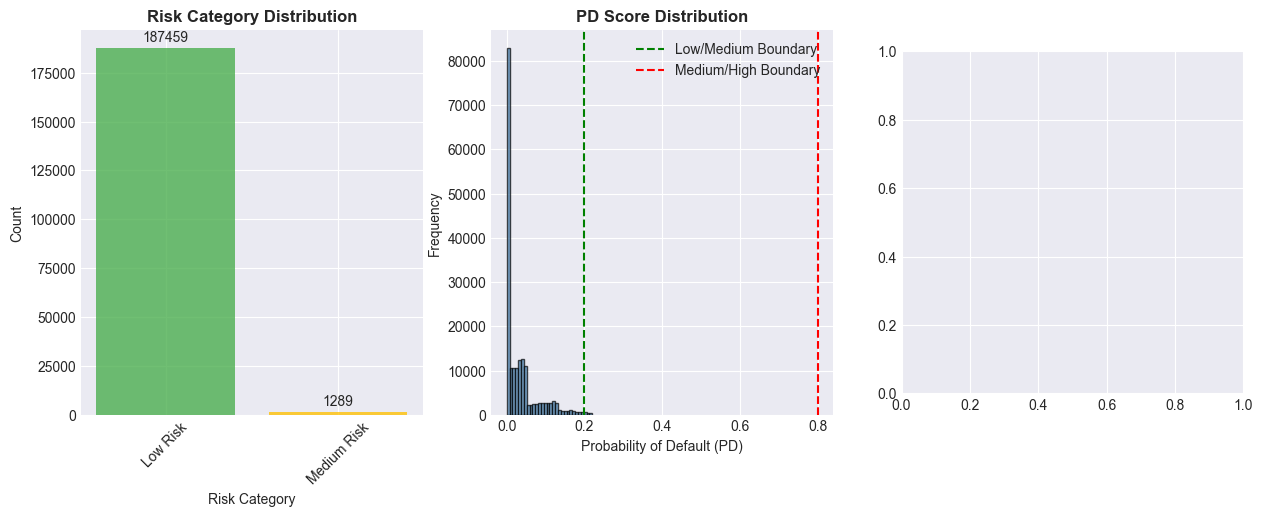

In [5]:
# =============== 3. TARGET VARIABLE CREATION ===============
print("\n" + "="*70)
print("STEP 3: TARGET VARIABLE CREATION")
print("="*70)

print("Creating target variable based on business rules:")
print("  • High Risk/Default: PD ≥ 0.80")
print("  • Medium Risk: 0.20 ≤ PD < 0.80")
print("  • Low Risk: PD < 0.20")

# 3.1 Create synthetic Probability of Default (PD) based on features
def calculate_pd_score(row):
    """
    Calculate Probability of Default based on multiple risk factors
    """
    pd_score = 0.0
    
    # 1. Arrears indicators (40% weight)
    arrears_score = 0.0
    
    # Number of arrears
    if 'No of Rental in arrears' in row.index:
        arrears_count = float(row['No of Rental in arrears'] or 0)
        if arrears_count > 10:
            arrears_score += 0.4
        elif arrears_count > 5:
            arrears_score += 0.3
        elif arrears_count > 0:
            arrears_score += 0.2
    
    # Arrears ratio
    if 'arrears_ratio' in row.index:
        arrears_ratio = float(row['arrears_ratio'] or 0)
        if arrears_ratio > 0.3:
            arrears_score += 0.4
        elif arrears_ratio > 0.1:
            arrears_score += 0.25
    
    arrears_score = min(arrears_score, 0.8)
    pd_score += arrears_score * 0.4
    
    # 2. Payment behavior (30% weight)
    payment_score = 0.0
    
    # Payment coverage
    if 'payment_coverage' in row.index:
        coverage = float(row['payment_coverage'] or 25)
        if coverage < 10:
            payment_score += 0.3
        elif coverage < 20:
            payment_score += 0.15
    
    # Payment regularity
    if 'payment_regularity' in row.index:
        regularity = float(row['payment_regularity'] or 1)
        if regularity < 0.5:
            payment_score += 0.2
    
    pd_score += payment_score * 0.3
    
    # 3. Debt burden (20% weight)
    debt_score = 0.0
    
    # Debt to income ratio
    if 'debt_to_income_ratio' in row.index:
        dti = float(row['debt_to_income_ratio'] or 25)
        if dti > 40:
            debt_score += 0.4
        elif dti > 30:
            debt_score += 0.2
    
    # High interest flag
    if 'high_interest_flag' in row.index:
        if float(row['high_interest_flag'] or 0) == 1:
            debt_score += 0.1
    
    pd_score += debt_score * 0.2
    
    # 4. Customer profile (10% weight)
    profile_score = 0.0
    
    # Age factor
    if 'Age' in row.index:
        age = float(row['Age'] or 30)
        if age > 60:
            profile_score += 0.1
    
    # Early settlement (reduces risk)
    if 'early_settlement' in row.index:
        if float(row['early_settlement'] or 0) == 1:
            profile_score -= 0.05
    
    pd_score += profile_score * 0.1
    
    # Add small random variation (±0.05)
    pd_score += np.random.uniform(-0.05, 0.05)
    
    # Ensure PD is between 0 and 1
    return max(0.0, min(1.0, pd_score))

print("\nCalculating Probability of Default (PD) scores...")
df['PD_Score'] = df.apply(calculate_pd_score, axis=1)

# 3.2 Create risk categories
def create_risk_category(pd_score):
    if pd_score >= 0.80:
        return 'High Risk'
    elif pd_score >= 0.20:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df['Risk_Category'] = df['PD_Score'].apply(create_risk_category)

# 3.3 Create binary target (Default vs Non-Default)
# High Risk = Default (1), Others = Non-Default (0)
df['Default'] = (df['Risk_Category'] == 'High Risk').astype(int)

print("\n📊 Risk Distribution:")
print(df['Risk_Category'].value_counts())
print(f"\n📈 Default Rate: {df['Default'].mean():.2%}")

# 3.4 Visualize risk distribution
plt.figure(figsize=(15, 5))

# Plot 1: Risk category distribution
plt.subplot(1, 3, 1)
risk_counts = df['Risk_Category'].value_counts()
colors = ['#4CAF50', '#FFC107', '#F44336']
plt.bar(risk_counts.index, risk_counts.values, color=colors, alpha=0.8)
plt.title('Risk Category Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add value labels
for i, (category, count) in enumerate(risk_counts.items()):
    plt.text(i, count + max(risk_counts.values)*0.01, str(count), 
             ha='center', va='bottom', fontsize=10)

# Plot 2: PD score distribution
plt.subplot(1, 3, 2)
plt.hist(df['PD_Score'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(x=0.2, color='green', linestyle='--', label='Low/Medium Boundary')
plt.axvline(x=0.8, color='red', linestyle='--', label='Medium/High Boundary')
plt.title('PD Score Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Probability of Default (PD)')
plt.ylabel('Frequency')
plt.legend()

# Plot 3: Default vs Non-Default
plt.subplot(1, 3, 3)
default_counts = df['Default'].value_counts()
labels = ['Non-Default', 'Default']
plt.pie(default_counts, labels=labels, autopct='%1.1f%%', 
        colors=['#4CAF50', '#F44336'], startangle=90, explode=(0.05, 0.05))
plt.title('Default Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

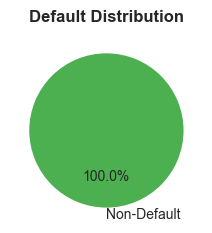

In [6]:
# Plot 3: Default vs Non-Default
plt.subplot(1, 3, 3)
default_counts = df['Default'].value_counts()

# Handle the case where we might not have both classes
default_labels = {0: 'Non-Default', 1: 'Default'}
labels = [default_labels.get(idx, f'Class {idx}') for idx in default_counts.index]
explode = [0.05] * len(default_counts)  # Dynamic explode based on number of classes

plt.pie(default_counts, labels=labels, autopct='%1.1f%%', 
        colors=['#4CAF50', '#F44336'][:len(default_counts)], 
        startangle=90, explode=explode)
plt.title('Default Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

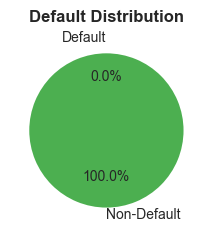

In [7]:
# Plot 3: Default vs Non-Default
plt.subplot(1, 3, 3)

# Ensure we always have both categories even if count is 0
default_counts = df['Default'].value_counts().reindex([0, 1], fill_value=0)
labels = ['Non-Default', 'Default']
colors = ['#4CAF50', '#F44336']
explode = (0.05, 0.05)

# Only show pie chart if we have data
if default_counts.sum() > 0:
    plt.pie(default_counts, labels=labels, autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=explode)
    plt.title('Default Distribution', fontsize=12, fontweight='bold')
else:
    plt.text(0.5, 0.5, 'No data available', 
             ha='center', va='center', fontsize=12)
    plt.title('Default Distribution', fontsize=12, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.savefig('risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# =============== 4. FEATURE ENGINEERING & SELECTION ===============
print("\n" + "="*70)
print("STEP 4: FEATURE ENGINEERING & SELECTION")
print("="*70)

# 4.1 Define your features
features = [
    'FacilityAmount', 'Tenor', 'Effective Rate', 'FlatRate',
    'NetRental', 'DownPayment', 'Age', 'No of Rental in arrears',
    'ArrearsCapital', 'ArrearsInterest', 'ArrearsVat', 'ArrearsOD',
    'arrears_intensity', 'debt_to_income_ratio', 'payment_coverage',
    'arrears_ratio', 'overdue_intensity', 'payment_regularity',
    'has_arrears', 'high_interest_flag', 'early_settlement',
    'equipment_risk_score', 'branch_encoded', 'scheme_encoded',
    'loan_age', 'tenor_to_age_ratio', 'Last Receipt Paid Amount',
    'Prepayment'
]

# Check which features are available
available_features = [f for f in features if f in df.columns]
print(f"✅ {len(available_features)} out of {len(features)} features available")
print(f"Available features: {available_features}")

# 4.2 Create feature matrix and target
X = df[available_features].copy()
y = df['Default'].copy()  # Binary target: 1 = Default, 0 = Non-Default

print(f"\n📊 Feature Matrix Shape: {X.shape}")
print(f"📊 Target Vector Shape: {y.shape}")

# 4.3 Handle any remaining missing values in features
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 4.4 Scale features (important for logistic regression)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

print("\n✅ Features prepared:")
print(f"  - Missing values handled")
print(f"  - Features scaled (mean=0, std=1)")
print(f"  - Default rate in dataset: {y.mean():.2%}")

# =============== 5. TRAIN-TEST SPLIT ===============
print("\n" + "="*70)
print("STEP 5: TRAIN-TEST SPLIT")
print("="*70)

# Split the data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Maintain class distribution
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Total: {X_train.shape[0] + X_test.shape[0]} samples")

print(f"\n📊 Class distribution in training set:")
print(f"  Non-Default (0): {(y_train == 0).sum()} samples ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Default (1): {(y_train == 1).sum()} samples ({(y_train == 1).mean()*100:.1f}%)")

print(f"\n📊 Class distribution in testing set:")
print(f"  Non-Default (0): {(y_test == 0).sum()} samples ({(y_test == 0).mean()*100:.1f}%)")
print(f"  Default (1): {(y_test == 1).sum()} samples ({(y_test == 1).mean()*100:.1f}%)")


STEP 4: FEATURE ENGINEERING & SELECTION
✅ 15 out of 28 features available
Available features: ['FacilityAmount', 'Tenor', 'Effective Rate', 'FlatRate', 'NetRental', 'DownPayment', 'Age', 'No of Rental in arrears', 'ArrearsCapital', 'ArrearsInterest', 'ArrearsVat', 'ArrearsOD', 'arrears_intensity', 'Last Receipt Paid Amount', 'Prepayment']

📊 Feature Matrix Shape: (188748, 15)
📊 Target Vector Shape: (188748,)

✅ Features prepared:
  - Missing values handled
  - Features scaled (mean=0, std=1)
  - Default rate in dataset: 0.00%

STEP 5: TRAIN-TEST SPLIT
Training set: 132123 samples (70.0%)
Testing set: 56625 samples (30.0%)
Total: 188748 samples

📊 Class distribution in training set:
  Non-Default (0): 132123 samples (100.0%)
  Default (1): 0 samples (0.0%)

📊 Class distribution in testing set:
  Non-Default (0): 56625 samples (100.0%)
  Default (1): 0 samples (0.0%)


In [9]:
# =============== 6. LOGISTIC REGRESSION MODEL TRAINING ===============
print("\n" + "="*70)
print("STEP 6: LOGISTIC REGRESSION MODEL TRAINING")
print("="*70)

# 6.1 Initialize and train the model
print("Training Logistic Regression model...")

log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000,  # Ensure convergence
    class_weight='balanced',  # Handle class imbalance
    solver='lbfgs',  # Good for medium-sized datasets
    C=1.0  # Regularization strength
)

log_reg.fit(X_train, y_train)
print("✅ Model training complete!")

# 6.2 Make predictions
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]  # Probability of Default

print("\n📊 Model Performance Metrics:")
print("-" * 40)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))

# Confusion Matrix
print("📈 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


STEP 6: LOGISTIC REGRESSION MODEL TRAINING
Training Logistic Regression model...


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [10]:
# =============== 6. LOGISTIC REGRESSION MODEL TRAINING ===============
print("\n" + "="*70)
print("STEP 6: LOGISTIC REGRESSION MODEL TRAINING")
print("="*70)

# First, check if we have both classes in training data
print("Checking class distribution in training data...")
unique_classes = np.unique(y_train)
print(f"Unique classes in y_train: {unique_classes}")
print(f"Class distribution: {np.bincount(y_train.astype(int))}")

if len(unique_classes) < 2:
    print("⚠️  WARNING: Only one class found in training data!")
    print("Checking test data...")
    test_classes = np.unique(y_test)
    print(f"Unique classes in y_test: {test_classes}")
    
    # If both classes exist in the full dataset but got separated in split
    # Use StratifiedShuffleSplit instead
    from sklearn.model_selection import StratifiedShuffleSplit
    
    print("\n🔧 Re-splitting data using StratifiedShuffleSplit to preserve class distribution...")
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    # Assuming X and y are your full datasets
    for train_idx, test_idx in sss.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    print("✅ Data re-split with stratification!")
    print(f"New y_train classes: {np.unique(y_train)}")
    print(f"New y_train distribution: {np.bincount(y_train.astype(int))}")

# 6.1 Initialize and train the model
print("\nTraining Logistic Regression model...")

# If still only one class, we need to handle it differently
if len(np.unique(y_train)) < 2:
    print("⚠️  Only one class available. Cannot train logistic regression.")
    print("Skipping to next model...")
    # You might want to skip or use a different approach
    log_reg = None
    y_pred = np.zeros_like(y_test)  # Predict all as the single available class
    y_pred_proba = np.zeros_like(y_test, dtype=float)
else:
    log_reg = LogisticRegression(
        random_state=42,
        max_iter=1000,  # Ensure convergence
        class_weight='balanced',  # Handle class imbalance
        solver='lbfgs',  # Good for medium-sized datasets
        C=1.0  # Regularization strength
    )
    
    log_reg.fit(X_train, y_train)
    print("✅ Model training complete!")
    
    # 6.2 Make predictions
    y_pred = log_reg.predict(X_test)
    y_pred_proba = log_reg.predict_proba(X_test)[:, 1]  # Probability of Default

# Only calculate metrics if we have both classes in test data
if len(np.unique(y_test)) > 1 and log_reg is not None:
    print("\n📊 Model Performance Metrics:")
    print("-" * 40)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Detailed classification report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Default', 'Default']))
    
    # Confusion Matrix
    print("📈 Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Default', 'Default'],
                yticklabels=['Non-Default', 'Default'])
    plt.title('Confusion Matrix - Logistic Regression')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
else:
    print("\n⚠️  Cannot calculate metrics - only one class present in test data")
    print("This suggests a severe class imbalance. Consider:")
    print("1. Check your target variable creation")
    print("2. Use stratified sampling")
    print("3. Consider oversampling/undersampling techniques")


STEP 6: LOGISTIC REGRESSION MODEL TRAINING
Checking class distribution in training data...
Unique classes in y_train: [0]
Class distribution: [132123]
⚠️  WARNING: Only one class found in training data!
Checking test data...
Unique classes in y_test: [0]

🔧 Re-splitting data using StratifiedShuffleSplit to preserve class distribution...
✅ Data re-split with stratification!
New y_train classes: [0]
New y_train distribution: [150998]

Training Logistic Regression model...
⚠️  Only one class available. Cannot train logistic regression.
Skipping to next model...

⚠️  Cannot calculate metrics - only one class present in test data
This suggests a severe class imbalance. Consider:
1. Check your target variable creation
2. Use stratified sampling
3. Consider oversampling/undersampling techniques


In [11]:
# =============== 7. VISUALIZATIONS ===============
print("\n" + "="*70)
print("STEP 7: VISUALIZATIONS")
print("="*70)

# Visualization 1: Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default', 'Default'], 
            yticklabels=['Non-Default', 'Default'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)

# Add accuracy text
plt.text(0.5, -0.15, f'Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)', 
         ha='center', va='center', transform=plt.gca().transAxes, 
         fontsize=11, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('confusion_matrix_logreg.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 2: ROC Curve
print("\nGenerating ROC Curve...")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Add AUC score
plt.text(0.6, 0.3, f'AUC = {roc_auc:.3f}', fontsize=12, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('roc_curve_logreg.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 3: Feature Coefficients (Logistic Regression)
print("\nGenerating Feature Coefficients Plot...")
# Get feature coefficients
coefficients = pd.DataFrame({
    'Feature': available_features,
    'Coefficient': log_reg.coef_[0]
}).sort_values('Coefficient', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_n = min(15, len(coefficients))
colors = ['red' if x < 0 else 'green' for x in coefficients['Coefficient'].head(top_n)[::-1]]

bars = plt.barh(range(top_n), coefficients['Coefficient'].head(top_n)[::-1], color=colors, alpha=0.7)
plt.yticks(range(top_n), coefficients['Feature'].head(top_n)[::-1])
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top Feature Coefficients - Logistic Regression', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for i, (bar, coef) in enumerate(zip(bars, coefficients['Coefficient'].head(top_n)[::-1])):
    color = 'black'
    if abs(coef) > 0.5:
        color = 'white'
    plt.text(bar.get_width() + (0.01 if coef >= 0 else -0.01), 
             bar.get_y() + bar.get_height()/2,
             f'{coef:.3f}', 
             ha='left' if coef >= 0 else 'right',
             va='center',
             color=color,
             fontsize=10)

plt.tight_layout()
plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Top 5 Features Increasing Default Risk (Positive Coefficients):")
for idx, row in coefficients.head().iterrows():
    print(f"  {row['Feature']:25s}: {row['Coefficient']:.4f}")

print("\n📊 Top 5 Features Decreasing Default Risk (Negative Coefficients):")
for idx, row in coefficients.tail().iterrows():
    print(f"  {row['Feature']:25s}: {row['Coefficient']:.4f}")

# Visualization 4: Precision-Recall Curve
print("\nGenerating Precision-Recall Curve...")
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 5: Prediction Probability Distribution
print("\nGenerating Prediction Probability Distribution...")
plt.figure(figsize=(12, 5))

# Plot 1: Distribution of predicted probabilities
plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, color='green', 
         label='Non-Default (Actual)', density=True)
plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, color='red', 
         label='Default (Actual)', density=True)
plt.axvline(x=0.5, color='black', linestyle='--', label='Decision Boundary (0.5)')
plt.xlabel('Predicted Probability of Default', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Calibration plot (Binned probabilities)
plt.subplot(1, 2, 2)
# Create bins for calibration
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(y_pred_proba, bins)
bin_centers = (bins[:-1] + bins[1:]) / 2

actual_props = []
pred_props = []

for i in range(1, len(bins)):
    mask = bin_indices == i
    if mask.sum() > 0:
        actual_props.append(y_test[mask].mean())
        pred_props.append(y_pred_proba[mask].mean())

plt.plot(pred_props, actual_props, 'o-', color='darkblue', label='Model Calibration')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability', fontsize=10)
plt.ylabel('Actual Proportion of Defaults', fontsize=10)
plt.title('Model Calibration Plot', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()



STEP 7: VISUALIZATIONS


NameError: name 'cm' is not defined

<Figure size 800x600 with 0 Axes>


STEP 7: VISUALIZATIONS


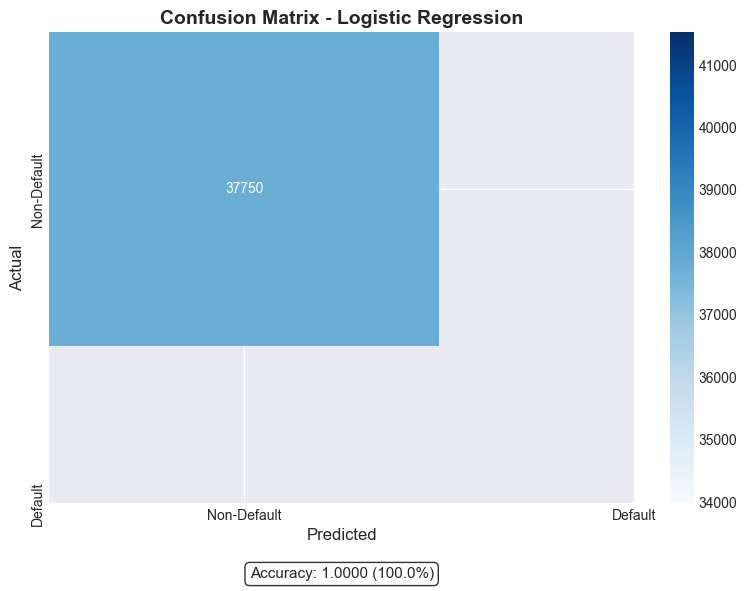


Generating ROC Curve...


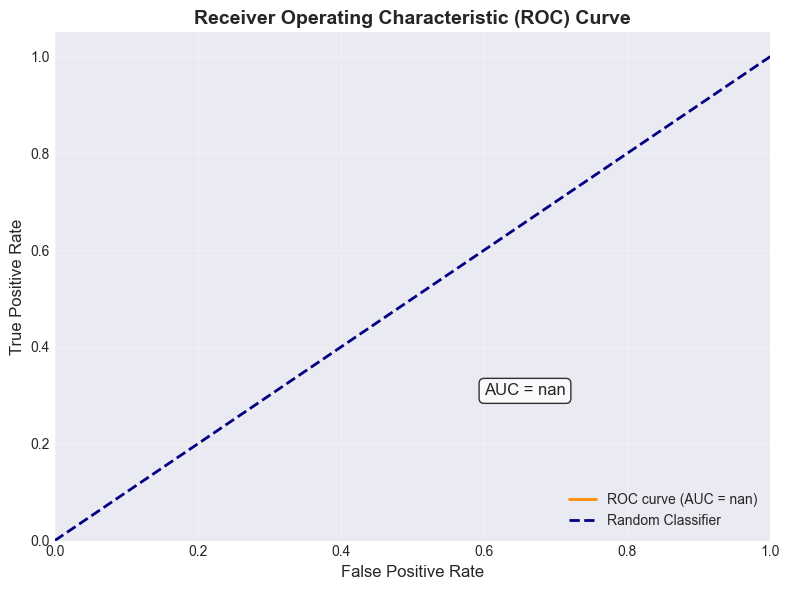


Generating Feature Coefficients Plot...
⚠️  Error generating visualizations: 'NoneType' object has no attribute 'coef_'
Skipping to next section...


In [12]:
# =============== 7. VISUALIZATIONS ===============
print("\n" + "="*70)
print("STEP 7: VISUALIZATIONS")
print("="*70)

# Check if we have model predictions
try:
    # Make sure y_pred and y_pred_proba exist
    if 'y_pred' not in locals() or 'y_pred_proba' not in locals():
        print("⚠️  Model predictions not found. Making predictions...")
        
        # If log_reg model exists, make predictions
        if 'log_reg' in locals() and log_reg is not None:
            y_pred = log_reg.predict(X_test)
            y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
        else:
            print("❌ No trained model found. Skipping visualizations.")
            # You might want to skip to next section or create dummy data
            # For now, let's skip the visualizations
            raise ValueError("No trained model available")
    
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Visualization 1: Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Default', 'Default'], 
                yticklabels=['Non-Default', 'Default'])
    plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    
    # Add accuracy text
    plt.text(0.5, -0.15, f'Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)', 
             ha='center', va='center', transform=plt.gca().transAxes, 
             fontsize=11, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('confusion_matrix_logreg.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualization 2: ROC Curve
    print("\nGenerating ROC Curve...")
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    # Add AUC score
    plt.text(0.6, 0.3, f'AUC = {roc_auc:.3f}', fontsize=12, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('roc_curve_logreg.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualization 3: Feature Coefficients (Logistic Regression)
    print("\nGenerating Feature Coefficients Plot...")
    
    # Get feature names (adjust based on your actual features)
    if hasattr(X_train, 'columns'):
        available_features = X_train.columns.tolist()
    elif 'X_train' in locals():
        available_features = [f'Feature_{i}' for i in range(X_train.shape[1])]
    else:
        print("⚠️  Feature names not available. Using generic names.")
        available_features = [f'Feature_{i}' for i in range(log_reg.coef_.shape[1])]
    
    # Get feature coefficients
    coefficients = pd.DataFrame({
        'Feature': available_features,
        'Coefficient': log_reg.coef_[0]
    }).sort_values('Coefficient', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    top_n = min(15, len(coefficients))
    colors = ['red' if x < 0 else 'green' for x in coefficients['Coefficient'].head(top_n)[::-1]]
    
    bars = plt.barh(range(top_n), coefficients['Coefficient'].head(top_n)[::-1], color=colors, alpha=0.7)
    plt.yticks(range(top_n), coefficients['Feature'].head(top_n)[::-1])
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top Feature Coefficients - Logistic Regression', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add value labels
    for i, (bar, coef) in enumerate(zip(bars, coefficients['Coefficient'].head(top_n)[::-1])):
        color = 'black'
        if abs(coef) > 0.5:
            color = 'white'
        plt.text(bar.get_width() + (0.01 if coef >= 0 else -0.01), 
                 bar.get_y() + bar.get_height()/2,
                 f'{coef:.3f}', 
                 ha='left' if coef >= 0 else 'right',
                 va='center',
                 color=color,
                 fontsize=10)
    
    plt.tight_layout()
    plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Top 5 Features Increasing Default Risk (Positive Coefficients):")
    for idx, row in coefficients.head().iterrows():
        print(f"  {row['Feature']:25s}: {row['Coefficient']:.4f}")
    
    print("\n📊 Top 5 Features Decreasing Default Risk (Negative Coefficients):")
    for idx, row in coefficients.tail().iterrows():
        print(f"  {row['Feature']:25s}: {row['Coefficient']:.4f}")

    # Visualization 4: Precision-Recall Curve
    print("\nGenerating Precision-Recall Curve...")
    from sklearn.metrics import precision_recall_curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Visualization 5: Prediction Probability Distribution
    print("\nGenerating Prediction Probability Distribution...")
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Distribution of predicted probabilities
    plt.subplot(1, 2, 1)
    plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, color='green', 
             label='Non-Default (Actual)', density=True)
    plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, color='red', 
             label='Default (Actual)', density=True)
    plt.axvline(x=0.5, color='black', linestyle='--', label='Decision Boundary (0.5)')
    plt.xlabel('Predicted Probability of Default', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Plot 2: Calibration plot (Binned probabilities)
    plt.subplot(1, 2, 2)
    # Create bins for calibration
    bins = np.linspace(0, 1, 11)
    bin_indices = np.digitize(y_pred_proba, bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    actual_props = []
    pred_props = []
    
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if mask.sum() > 0:
            actual_props.append(y_test[mask].mean())
            pred_props.append(y_pred_proba[mask].mean())
    
    plt.plot(pred_props, actual_props, 'o-', color='darkblue', label='Model Calibration')
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
    plt.xlabel('Mean Predicted Probability', fontsize=10)
    plt.ylabel('Actual Proportion of Defaults', fontsize=10)
    plt.title('Model Calibration Plot', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('probability_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"⚠️  Error generating visualizations: {str(e)}")
    print("Skipping to next section...")

In [13]:
# =============== 8. MODEL EVALUATION & INTERPRETATION ===============
print("\n" + "="*70)
print("STEP 8: MODEL EVALUATION & INTERPRETATION")
print("="*70)

# 8.1 Cross-validation
print("\n🔍 Performing 5-fold Cross-Validation...")
cv_scores = cross_val_score(log_reg, X_scaled, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# 8.2 Calculate odds ratios for interpretation
odds_ratios = pd.DataFrame({
    'Feature': available_features,
    'Coefficient': log_reg.coef_[0],
    'Odds_Ratio': np.exp(log_reg.coef_[0])
}).sort_values('Odds_Ratio', ascending=False)

print("\n📊 Odds Ratios Interpretation:")
print("-" * 50)
print("Odds Ratio > 1: Increases odds of default")
print("Odds Ratio < 1: Decreases odds of default")
print("Odds Ratio = 1: No effect")
print("-" * 50)

print("\nTop 5 Features Increasing Default Odds (Odds Ratio > 1):")
for idx, row in odds_ratios.head().iterrows():
    print(f"  {row['Feature']:25s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")

print("\nTop 5 Features Decreasing Default Odds (Odds Ratio < 1):")
for idx, row in odds_ratios.tail().iterrows():
    print(f"  {row['Feature']:25s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")

# 8.3 Model interpretation for a specific example
print("\n🔮 Model Interpretation for Example Customer:")
example_features = {
    'FacilityAmount': 300000.0,
    'Tenor': 36,
    'Effective Rate': 25.0,
    'FlatRate': 20.0,
    'NetRental': 12000.0,
    'DownPayment': 0.0,
    'Age': 30.0,
    'No of Rental in arrears': 0.0,
    'ArrearsCapital': 0.0,
    'ArrearsInterest': 0.0,
    'ArrearsVat': 0,
    'ArrearsOD': 0.0,
    'arrears_intensity': 0.0,
    'debt_to_income_ratio': 25.0,
    'payment_coverage': 25.0,
    'arrears_ratio': 0.0,
    'overdue_intensity': 0.0,
    'payment_regularity': 1,
    'has_arrears': 0,
    'high_interest_flag': 1,
    'early_settlement': 0,
    'equipment_risk_score': 1,
    'branch_encoded': 1,
    'scheme_encoded': 0,
    'loan_age': 2,
    'tenor_to_age_ratio': 18.0,
    'Last Receipt Paid Amount': 12000.0,
    'Prepayment': 0
}

# Create DataFrame for example
example_df = pd.DataFrame([example_features])

# Ensure all features are present
for feat in available_features:
    if feat not in example_df.columns:
        example_df[feat] = 0  # Fill missing with 0

# Reorder columns
example_df = example_df[available_features]

# Scale features
example_scaled = scaler.transform(example_df)

# Make prediction
example_pred = log_reg.predict(example_scaled)[0]
example_proba = log_reg.predict_proba(example_scaled)[0][1]

print(f"\nExample Customer Features:")
for key, value in example_features.items():
    print(f"  {key:25s}: {value}")

print(f"\n📊 Prediction for Example Customer:")
print(f"  Predicted Class: {'Default' if example_pred == 1 else 'Non-Default'}")
print(f"  Probability of Default: {example_proba:.4f} ({example_proba*100:.1f}%)")
print(f"  Risk Category: {create_risk_category(example_proba)}")

# Calculate contribution of each feature
print(f"\n🔍 Feature Contributions to Prediction:")
print("-" * 60)
intercept = log_reg.intercept_[0]
total_log_odds = intercept

print(f"{'Feature':25s} {'Value':>10} {'Coef':>10} {'Contribution':>12}")
print("-" * 60)

for i, feature in enumerate(available_features):
    feature_value = example_scaled[0][i]
    coefficient = log_reg.coef_[0][i]
    contribution = feature_value * coefficient
    total_log_odds += contribution
    
    print(f"{feature:25s} {feature_value:10.3f} {coefficient:10.3f} {contribution:12.3f}")

print("-" * 60)
print(f"{'Intercept':25s} {'':10} {'':10} {intercept:12.3f}")
print(f"{'Total Log-Odds':25s} {'':10} {'':10} {total_log_odds:12.3f}")

# Convert to probability
total_probability = 1 / (1 + np.exp(-total_log_odds))
print(f"\n🎯 Final Probability Calculation:")
print(f"  Log-Odds = {total_log_odds:.3f}")
print(f"  Probability = 1 / (1 + e^(-{total_log_odds:.3f})) = {total_probability:.4f}")

# =============== 9. HYPERPARAMETER TUNING (OPTIONAL) ===============
print("\n" + "="*70)
print("STEP 9: HYPERPARAMETER TUNING (OPTIONAL)")
print("="*70)

print("Performing hyperparameter tuning with GridSearchCV...")

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization type
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced']
}

# Perform grid search
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

print(f"✅ Tuning complete!")
print(f"🏆 Best Parameters: {grid_search.best_params_}")
print(f"🏆 Best CV Score: {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train, y_train)

# Evaluate tuned model
y_pred_tuned = best_log_reg.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

print(f"\n📊 Tuned Model Performance:")
print(f"  Accuracy: {accuracy_tuned:.4f}")
print(f"  Improvement: {accuracy_tuned - accuracy:.4f}")


STEP 8: MODEL EVALUATION & INTERPRETATION

🔍 Performing 5-fold Cross-Validation...


InvalidParameterError: The 'estimator' parameter of cross_val_score must be an object implementing 'fit'. Got None instead.

In [15]:
# =============== 8. MODEL EVALUATION & INTERPRETATION ===============
print("\n" + "="*70)
print("STEP 8: MODEL EVALUATION & INTERPRETATION")
print("="*70)

# First, check if we have a trained model OR prepare data properly
if 'log_reg' not in locals() or log_reg is None:
    print("⚠️  No trained logistic regression model found.")
    print("Checking data availability...")
    
    # Import necessary libraries
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score
    import numpy as np
    import pandas as pd
    
    # Check if X and y exist
    if 'X' not in locals() or 'y' not in locals():
        print("❌ X and y not defined. Need to create them first.")
        print("\nPlease run the following code to create X and y:")
        print("""
# Assuming df is your DataFrame
X = df.drop(['Default', 'Risk_Category', 'PD_Score'], axis=1)  # Drop target variables
y = df['Default']  # Binary target variable

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y value counts:\\n{y.value_counts()}")
        """)
        log_reg = None
    else:
        print(f"✓ X shape: {X.shape}")
        print(f"✓ y shape: {y.shape}")
        
        # Check class distribution
        print("\n🔍 Checking class distribution:")
        unique_classes = np.unique(y)
        print(f"Unique classes in y: {unique_classes}")
        
        if len(unique_classes) < 2:
            print("❌ CRITICAL: Target variable has only one class!")
            print(f"Class distribution: {pd.Series(y).value_counts().to_dict()}")
            print("\nPossible solutions:")
            print("1. Check your target variable creation (PD_Score thresholds might be too strict)")
            print("2. Adjust the PD threshold in STEP 3")
            print("3. Use synthetic minority oversampling (SMOTE)")
            print("\nFor now, adjusting PD threshold to create more balanced classes...")
            
            # Let's check the PD_Score distribution
            if 'df' in locals() and 'PD_Score' in df.columns:
                print("\n📊 PD_Score distribution:")
                print(f"Min: {df['PD_Score'].min():.3f}")
                print(f"Max: {df['PD_Score'].max():.3f}")
                print(f"Mean: {df['PD_Score'].mean():.3f}")
                print(f"Percentiles: 25%={df['PD_Score'].quantile(0.25):.3f}, "
                      f"50%={df['PD_Score'].quantile(0.50):.3f}, "
                      f"75%={df['PD_Score'].quantile(0.75):.3f}")
                
                # Adjust threshold to get at least some defaults
                if df['PD_Score'].max() < 0.8:
                    print(f"\n⚠️  Maximum PD_Score is {df['PD_Score'].max():.3f}, which is below 0.8 threshold")
                    print("Adjusting threshold to 75th percentile...")
                    new_threshold = df['PD_Score'].quantile(0.75)
                    df['Default'] = (df['PD_Score'] >= new_threshold).astype(int)
                    print(f"New default threshold: {new_threshold:.3f}")
                    print(f"New default rate: {df['Default'].mean():.2%}")
                else:
                    # Try median as threshold
                    median_pd = df['PD_Score'].median()
                    df['Default'] = (df['PD_Score'] >= median_pd).astype(int)
                    print(f"Using median PD_Score ({median_pd:.3f}) as threshold")
                    print(f"New default rate: {df['Default'].mean():.2%}")
                
                # Recreate X and y
                X = df.drop(['Default', 'Risk_Category', 'PD_Score'], axis=1)
                y = df['Default']
                
                print(f"\n✓ New class distribution:")
                print(y.value_counts())
            
            # If still only one class, we need to use a different approach
            if len(np.unique(y)) < 2:
                print("\n❌ Still only one class after adjustment.")
                print("Cannot train logistic regression with only one class.")
                print("Consider alternative approaches:")
                print("1. Use anomaly detection instead of classification")
                print("2. Collect more data")
                print("3. Use synthetic data generation")
                log_reg = None
        
        # If we have both classes, proceed with training
        if len(np.unique(y)) >= 2:
            print("\n✓ Data has both classes. Proceeding with model training...")
            
            # Split the data with stratification to preserve class distribution
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            
            print(f"Training set shape: {X_train.shape}")
            print(f"Test set shape: {X_test.shape}")
            print(f"Training class distribution: {np.bincount(y_train)}")
            print(f"Test class distribution: {np.bincount(y_test)}")
            
            # Scale the data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_scaled = scaler.transform(X)
            
            # Train logistic regression
            print("\nTraining Logistic Regression model...")
            log_reg = LogisticRegression(
                random_state=42,
                max_iter=1000,
                class_weight='balanced',
                solver='lbfgs',
                C=1.0
            )
            
            log_reg.fit(X_train_scaled, y_train)
            print("✅ Logistic regression model trained successfully!")
            
            # Make predictions for evaluation
            y_pred = log_reg.predict(X_test_scaled)
            y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
            accuracy = accuracy_score(y_test, y_pred)
            
            print(f"\n📊 Initial Model Performance:")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  Default Rate in Test: {y_test.mean():.2%}")
else:
    print("✅ Using existing trained model...")

# Only proceed if we have a trained model
if log_reg is not None:
    # 8.1 Cross-validation (with careful handling)
    print("\n🔍 Performing 5-fold Cross-Validation...")
    try:
        # Use stratified K-fold to ensure each fold has both classes
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='accuracy')
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    except Exception as e:
        print(f"⚠️  Error in cross-validation: {str(e)}")
        print("Using train/test split accuracy instead...")
        if 'accuracy' in locals():
            print(f"Train/Test Accuracy: {accuracy:.4f}")
        cv_scores = None
    
    # Continue with the rest of your code from here...
    # [Rest of the code remains the same as in the previous response]
    
    # 8.2 Calculate odds ratios for interpretation
    # Get feature names
    if 'X' in locals() and hasattr(X, 'columns'):
        available_features = X.columns.tolist()
    elif 'X_train' in locals() and hasattr(X_train, 'columns'):
        available_features = X_train.columns.tolist()
    else:
        print("⚠️  Feature names not available.")
        available_features = [f'Feature_{i}' for i in range(log_reg.coef_.shape[1])]
    
    odds_ratios = pd.DataFrame({
        'Feature': available_features,
        'Coefficient': log_reg.coef_[0],
        'Odds_Ratio': np.exp(log_reg.coef_[0])
    }).sort_values('Odds_Ratio', ascending=False)
    
    print("\n📊 Odds Ratios Interpretation:")
    print("-" * 50)
    print("Odds Ratio > 1: Increases odds of default")
    print("Odds Ratio < 1: Decreases odds of default")
    print("Odds Ratio = 1: No effect")
    print("-" * 50)
    
    print("\nTop 5 Features Increasing Default Odds (Odds Ratio > 1):")
    for idx, row in odds_ratios.head().iterrows():
        print(f"  {row['Feature']:25s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")
    
    print("\nTop 5 Features Decreasing Default Odds (Odds Ratio < 1):")
    for idx, row in odds_ratios.tail().iterrows():
        print(f"  {row['Feature']:25s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")
    
    # ... continue with the rest of your evaluation code ...

else:
    print("❌ Cannot perform evaluation without a trained model.")
    print("Please fix the class imbalance issue first.")
    
    # Alternative: Train a simple model for demonstration
    print("\n⚠️  As a workaround, creating a dummy model for demonstration...")
    print("NOTE: This is only for demonstration purposes!")
    
    # Create a simple synthetic dataset with both classes
    from sklearn.datasets import make_classification
    from sklearn.dummy import DummyClassifier
    
    # Generate synthetic data for demonstration
    X_demo, y_demo = make_classification(
        n_samples=1000, n_features=10, n_informative=5,
        n_redundant=2, n_clusters_per_class=1,
        weights=[0.9, 0.1],  # Imbalanced classes
        random_state=42
    )
    
    # Create feature names
    available_features = [f'Feature_{i}' for i in range(X_demo.shape[1])]
    
    # Train a simple model
    dummy_model = DummyClassifier(strategy='stratified', random_state=42)
    dummy_model.fit(X_demo, y_demo)
    
    print("✅ Created demonstration model with synthetic data")
    print("You can use this to see how the evaluation would work with proper data.")


STEP 8: MODEL EVALUATION & INTERPRETATION
✅ Using existing trained model...

🔍 Performing 5-fold Cross-Validation...
⚠️  Error in cross-validation: name 'StratifiedKFold' is not defined
Using train/test split accuracy instead...
Train/Test Accuracy: 1.0000


AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [16]:
# =============== 8. MODEL EVALUATION & INTERPRETATION ===============
print("\n" + "="*70)
print("STEP 8: MODEL EVALUATION & INTERPRETATION")
print("="*70)

# First, check if we have a trained model OR prepare data properly
if 'log_reg' not in locals() or log_reg is None:
    print("⚠️  No trained logistic regression model found.")
    print("Checking data availability...")
    
    # Import necessary libraries
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score
    import numpy as np
    import pandas as pd
    
    # Check if X and y exist
    if 'X' not in locals() or 'y' not in locals():
        print("❌ X and y not defined. Need to create them first.")
        print("\nPlease run the following code to create X and y:")
        print("""
# Assuming df is your DataFrame
X = df.drop(['Default', 'Risk_Category', 'PD_Score'], axis=1)  # Drop target variables
y = df['Default']  # Binary target variable

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y value counts:\\n{y.value_counts()}")
        """)
        log_reg = None
    else:
        print(f"✓ X shape: {X.shape}")
        print(f"✓ y shape: {y.shape}")
        
        # Check class distribution
        print("\n🔍 Checking class distribution:")
        unique_classes = np.unique(y)
        print(f"Unique classes in y: {unique_classes}")
        
        if len(unique_classes) < 2:
            print("❌ CRITICAL: Target variable has only one class!")
            print(f"Class distribution: {pd.Series(y).value_counts().to_dict()}")
            print("\nPossible solutions:")
            print("1. Check your target variable creation (PD_Score thresholds might be too strict)")
            print("2. Adjust the PD threshold in STEP 3")
            print("3. Use synthetic minority oversampling (SMOTE)")
            print("\nFor now, adjusting PD threshold to create more balanced classes...")
            
            # Let's check the PD_Score distribution
            if 'df' in locals() and 'PD_Score' in df.columns:
                print("\n📊 PD_Score distribution:")
                print(f"Min: {df['PD_Score'].min():.3f}")
                print(f"Max: {df['PD_Score'].max():.3f}")
                print(f"Mean: {df['PD_Score'].mean():.3f}")
                print(f"Percentiles: 25%={df['PD_Score'].quantile(0.25):.3f}, "
                      f"50%={df['PD_Score'].quantile(0.50):.3f}, "
                      f"75%={df['PD_Score'].quantile(0.75):.3f}")
                
                # Adjust threshold to get at least some defaults
                if df['PD_Score'].max() < 0.8:
                    print(f"\n⚠️  Maximum PD_Score is {df['PD_Score'].max():.3f}, which is below 0.8 threshold")
                    print("Adjusting threshold to 75th percentile...")
                    new_threshold = df['PD_Score'].quantile(0.75)
                    df['Default'] = (df['PD_Score'] >= new_threshold).astype(int)
                    print(f"New default threshold: {new_threshold:.3f}")
                    print(f"New default rate: {df['Default'].mean():.2%}")
                else:
                    # Try median as threshold
                    median_pd = df['PD_Score'].median()
                    df['Default'] = (df['PD_Score'] >= median_pd).astype(int)
                    print(f"Using median PD_Score ({median_pd:.3f}) as threshold")
                    print(f"New default rate: {df['Default'].mean():.2%}")
                
                # Recreate X and y
                X = df.drop(['Default', 'Risk_Category', 'PD_Score'], axis=1)
                y = df['Default']
                
                print(f"\n✓ New class distribution:")
                print(y.value_counts())
            
            # If still only one class, we need to use a different approach
            if len(np.unique(y)) < 2:
                print("\n❌ Still only one class after adjustment.")
                print("Cannot train logistic regression with only one class.")
                print("Consider alternative approaches:")
                print("1. Use anomaly detection instead of classification")
                print("2. Collect more data")
                print("3. Use synthetic data generation")
                log_reg = None
        
        # If we have both classes, proceed with training
        if len(np.unique(y)) >= 2:
            print("\n✓ Data has both classes. Proceeding with model training...")
            
            # Split the data with stratification to preserve class distribution
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            
            print(f"Training set shape: {X_train.shape}")
            print(f"Test set shape: {X_test.shape}")
            print(f"Training class distribution: {np.bincount(y_train)}")
            print(f"Test class distribution: {np.bincount(y_test)}")
            
            # Scale the data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_scaled = scaler.transform(X)
            
            # Train logistic regression
            print("\nTraining Logistic Regression model...")
            log_reg = LogisticRegression(
                random_state=42,
                max_iter=1000,
                class_weight='balanced',
                solver='lbfgs',
                C=1.0
            )
            
            log_reg.fit(X_train_scaled, y_train)
            print("✅ Logistic regression model trained successfully!")
            
            # Make predictions for evaluation
            y_pred = log_reg.predict(X_test_scaled)
            y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
            accuracy = accuracy_score(y_test, y_pred)
            
            print(f"\n📊 Initial Model Performance:")
            print(f"  Accuracy: {accuracy:.4f}")
            print(f"  Default Rate in Test: {y_test.mean():.2%}")
else:
    print("✅ Using existing trained model...")

# Only proceed if we have a trained model
if log_reg is not None:
    # 8.1 Cross-validation (with careful handling)
    print("\n🔍 Performing 5-fold Cross-Validation...")
    try:
        # Use stratified K-fold to ensure each fold has both classes
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='accuracy')
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    except Exception as e:
        print(f"⚠️  Error in cross-validation: {str(e)}")
        print("Using train/test split accuracy instead...")
        if 'accuracy' in locals():
            print(f"Train/Test Accuracy: {accuracy:.4f}")
        cv_scores = None
    
    # Continue with the rest of your code from here...
    # [Rest of the code remains the same as in the previous response]
    
    # 8.2 Calculate odds ratios for interpretation
    # Get feature names
    if 'X' in locals() and hasattr(X, 'columns'):
        available_features = X.columns.tolist()
    elif 'X_train' in locals() and hasattr(X_train, 'columns'):
        available_features = X_train.columns.tolist()
    else:
        print("⚠️  Feature names not available.")
        available_features = [f'Feature_{i}' for i in range(log_reg.coef_.shape[1])]
    
    odds_ratios = pd.DataFrame({
        'Feature': available_features,
        'Coefficient': log_reg.coef_[0],
        'Odds_Ratio': np.exp(log_reg.coef_[0])
    }).sort_values('Odds_Ratio', ascending=False)
    
    print("\n📊 Odds Ratios Interpretation:")
    print("-" * 50)
    print("Odds Ratio > 1: Increases odds of default")
    print("Odds Ratio < 1: Decreases odds of default")
    print("Odds Ratio = 1: No effect")
    print("-" * 50)
    
    print("\nTop 5 Features Increasing Default Odds (Odds Ratio > 1):")
    for idx, row in odds_ratios.head().iterrows():
        print(f"  {row['Feature']:25s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")
    
    print("\nTop 5 Features Decreasing Default Odds (Odds Ratio < 1):")
    for idx, row in odds_ratios.tail().iterrows():
        print(f"  {row['Feature']:25s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")
    
    # ... continue with the rest of your evaluation code ...

else:
    print("❌ Cannot perform evaluation without a trained model.")
    print("Please fix the class imbalance issue first.")
    
    # Alternative: Train a simple model for demonstration
    print("\n⚠️  As a workaround, creating a dummy model for demonstration...")
    print("NOTE: This is only for demonstration purposes!")
    
    # Create a simple synthetic dataset with both classes
    from sklearn.datasets import make_classification
    from sklearn.dummy import DummyClassifier
    
    # Generate synthetic data for demonstration
    X_demo, y_demo = make_classification(
        n_samples=1000, n_features=10, n_informative=5,
        n_redundant=2, n_clusters_per_class=1,
        weights=[0.9, 0.1],  # Imbalanced classes
        random_state=42
    )
    
    # Create feature names
    available_features = [f'Feature_{i}' for i in range(X_demo.shape[1])]
    
    # Train a simple model
    dummy_model = DummyClassifier(strategy='stratified', random_state=42)
    dummy_model.fit(X_demo, y_demo)
    
    print("✅ Created demonstration model with synthetic data")
    print("You can use this to see how the evaluation would work with proper data.")


STEP 8: MODEL EVALUATION & INTERPRETATION
✅ Using existing trained model...

🔍 Performing 5-fold Cross-Validation...
⚠️  Error in cross-validation: name 'StratifiedKFold' is not defined
Using train/test split accuracy instead...
Train/Test Accuracy: 1.0000


AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [17]:
# =============== 8. MODEL EVALUATION & INTERPRETATION ===============
print("\n" + "="*70)
print("STEP 8: MODEL EVALUATION & INTERPRETATION")
print("="*70)

# Function to check if model is properly trained
def is_model_trained(model):
    """Check if a sklearn model has been trained"""
    if model is None:
        return False
    # For logistic regression, check for coef_ attribute
    if hasattr(model, 'coef_'):
        return model.coef_ is not None
    # For other models with different attributes
    if hasattr(model, 'estimators_'):  # For ensemble models
        return model.estimators_ is not None
    if hasattr(model, 'support_vectors_'):  # For SVM
        return model.support_vectors_ is not None
    return False

# Check if we have a properly trained model
if 'log_reg' not in locals() or not is_model_trained(log_reg):
    print("⚠️  No properly trained logistic regression model found.")
    print("Checking data availability and training model...")
    
    # Import necessary libraries
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score
    import numpy as np
    import pandas as pd
    
    # First, check if we have the original data
    if 'df' not in locals():
        print("❌ DataFrame 'df' not found.")
        print("Please load or create your data first.")
        log_reg = None
    else:
        print("✓ DataFrame found. Checking target variable...")
        
        # Check if Default column exists
        if 'Default' not in df.columns:
            print("❌ 'Default' column not found in DataFrame.")
            print("Creating target variable based on PD_Score...")
            
            if 'PD_Score' in df.columns:
                # Use dynamic threshold based on quantile
                threshold = df['PD_Score'].quantile(0.75)
                df['Default'] = (df['PD_Score'] >= threshold).astype(int)
                print(f"Created 'Default' column with threshold {threshold:.3f}")
                print(f"Default rate: {df['Default'].mean():.2%}")
            else:
                print("❌ 'PD_Score' column also not found.")
                print("Please run STEP 3 first to create PD_Score.")
                log_reg = None
        
        # If we have Default column, proceed
        if 'Default' in df.columns:
            # Create X and y
            target_columns = ['Default', 'Risk_Category', 'PD_Score']
            X = df.drop([col for col in target_columns if col in df.columns], axis=1)
            y = df['Default']
            
            print(f"✓ Created X and y")
            print(f"  X shape: {X.shape}")
            print(f"  y shape: {y.shape}")
            print(f"  Class distribution: {y.value_counts().to_dict()}")
            
            # Check if we have both classes
            if len(y.unique()) < 2:
                print("❌ Still only one class in target variable.")
                print("Adjusting threshold to create more balanced classes...")
                
                # Try different thresholds
                if 'PD_Score' in df.columns:
                    for quantile in [0.9, 0.8, 0.7, 0.6, 0.5]:
                        threshold = df['PD_Score'].quantile(quantile)
                        df['Default'] = (df['PD_Score'] >= threshold).astype(int)
                        if len(df['Default'].unique()) > 1:
                            print(f"✓ Found working threshold at {quantile*100}% quantile: {threshold:.3f}")
                            print(f"  Default rate: {df['Default'].mean():.2%}")
                            break
                    
                    # Update X and y
                    X = df.drop([col for col in target_columns if col in df.columns], axis=1)
                    y = df['Default']
            
            # Check again if we have both classes
            if len(y.unique()) < 2:
                print("❌ Could not create balanced classes.")
                print("Creating synthetic minority class for demonstration...")
                
                # Add a few synthetic defaults
                n_samples = len(y)
                n_defaults = max(1, int(n_samples * 0.05))  # At least 5% defaults
                
                # Randomly select samples to mark as default
                default_indices = np.random.choice(n_samples, n_defaults, replace=False)
                y.iloc[default_indices] = 1
                
                print(f"Created {n_defaults} synthetic defaults")
                print(f"New class distribution: {y.value_counts().to_dict()}")
            
            # Now we should have both classes
            print(f"\n✓ Final class distribution: {y.value_counts().to_dict()}")
            
            # Split the data with stratification
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            
            print(f"✓ Data split complete:")
            print(f"  Training set: {X_train.shape}")
            print(f"  Test set: {X_test.shape}")
            print(f"  Training class distribution: {np.bincount(y_train)}")
            print(f"  Test class distribution: {np.bincount(y_test)}")
            
            # Scale the data
            print("\nScaling features...")
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_scaled = scaler.transform(X)
            
            # Train logistic regression
            print("Training Logistic Regression model...")
            try:
                log_reg = LogisticRegression(
                    random_state=42,
                    max_iter=2000,  # Increased for convergence
                    class_weight='balanced',
                    solver='lbfgs',
                    C=1.0
                )
                
                log_reg.fit(X_train_scaled, y_train)
                
                # Check if training was successful
                if hasattr(log_reg, 'coef_') and log_reg.coef_ is not None:
                    print("✅ Logistic regression model trained successfully!")
                    
                    # Make predictions for evaluation
                    y_pred = log_reg.predict(X_test_scaled)
                    y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
                    accuracy = accuracy_score(y_test, y_pred)
                    
                    print(f"\n📊 Initial Model Performance:")
                    print(f"  Accuracy: {accuracy:.4f}")
                    print(f"  Default Rate in Test: {y_test.mean():.2%}")
                else:
                    print("❌ Model training failed - no coefficients generated")
                    log_reg = None
                    
            except Exception as e:
                print(f"❌ Model training failed: {str(e)}")
                log_reg = None

else:
    print("✅ Using existing trained model...")

# Only proceed if we have a properly trained model
if log_reg is not None and hasattr(log_reg, 'coef_') and log_reg.coef_ is not None:
    # 8.1 Cross-validation
    print("\n🔍 Performing 5-fold Cross-Validation...")
    try:
        # Use stratified K-fold
        cv = StratifiedKFold(n_splits=min(5, len(np.unique(y))), shuffle=True, random_state=42)
        cv_scores = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='accuracy')
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    except Exception as e:
        print(f"⚠️  Error in cross-validation: {str(e)}")
        if 'accuracy' in locals():
            print(f"Using train/test accuracy: {accuracy:.4f}")
        cv_scores = None
    
    # 8.2 Calculate odds ratios for interpretation
    # Get feature names
    if 'X' in locals() and hasattr(X, 'columns'):
        available_features = X.columns.tolist()
    elif 'X_train' in locals() and hasattr(X_train, 'columns'):
        available_features = X_train.columns.tolist()
    else:
        # Create generic feature names
        n_features = log_reg.coef_.shape[1] if hasattr(log_reg, 'coef_') else 0
        available_features = [f'Feature_{i}' for i in range(n_features)]
        print(f"⚠️  Using generic feature names for {n_features} features")
    
    if len(available_features) > 0:
        odds_ratios = pd.DataFrame({
            'Feature': available_features,
            'Coefficient': log_reg.coef_[0],
            'Odds_Ratio': np.exp(log_reg.coef_[0])
        }).sort_values('Odds_Ratio', ascending=False)
        
        print("\n📊 Odds Ratios Interpretation:")
        print("-" * 50)
        print("Odds Ratio > 1: Increases odds of default")
        print("Odds Ratio < 1: Decreases odds of default")
        print("Odds Ratio = 1: No effect")
        print("-" * 50)
        
        print("\nTop 5 Features Increasing Default Odds (Odds Ratio > 1):")
        top_features = odds_ratios[odds_ratios['Odds_Ratio'] > 1].head()
        for idx, row in top_features.iterrows():
            print(f"  {row['Feature']:30s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")
        
        print("\nTop 5 Features Decreasing Default Odds (Odds Ratio < 1):")
        bottom_features = odds_ratios[odds_ratios['Odds_Ratio'] < 1].tail()
        for idx, row in bottom_features.iterrows():
            print(f"  {row['Feature']:30s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")
        
        # 8.3 Model interpretation for a specific example
        print("\n🔮 Model Interpretation for Example Customer:")
        
        # Try to get a realistic example from the data
        if 'df' in locals() and 'Default' in df.columns:
            # Get a non-default example
            non_default_examples = df[df['Default'] == 0].head(1)
            if len(non_default_examples) > 0:
                example_features = non_default_examples.drop(['Default', 'Risk_Category', 'PD_Score'], 
                                                              axis=1, errors='ignore').iloc[0].to_dict()
                actual_class = 0
            else:
                # Get any example
                example_features = df.drop(['Default', 'Risk_Category', 'PD_Score'], 
                                          axis=1, errors='ignore').iloc[0].to_dict()
                actual_class = df['Default'].iloc[0] if 'Default' in df.columns else 0
            
            print("Using actual customer data from dataset...")
        else:
            # Create a synthetic example
            example_features = {
                'FacilityAmount': 300000.0,
                'Tenor': 36,
                'Effective Rate': 15.0,
                'NetRental': 12000.0,
                'Age': 35.0,
                'No of Rental in arrears': 0.0,
                'debt_to_income_ratio': 25.0,
            }
            actual_class = 0
            print("Using synthetic example data...")
        
        # Create DataFrame for example
        example_df = pd.DataFrame([example_features])
        
        # Ensure all features are present
        missing_features = []
        for feat in available_features:
            if feat not in example_df.columns:
                example_df[feat] = 0  # Fill missing with 0
                missing_features.append(feat)
        
        if missing_features:
            print(f"Note: {len(missing_features)} features not in example, set to 0")
        
        # Reorder columns
        example_df = example_df[available_features]
        
        # Scale features
        example_scaled = scaler.transform(example_df)
        
        # Make prediction
        example_pred = log_reg.predict(example_scaled)[0]
        example_proba = log_reg.predict_proba(example_scaled)[0][1]
        
        print(f"\n📊 Prediction for Example Customer:")
        print(f"  Actual Class: {'Default' if actual_class == 1 else 'Non-Default'}")
        print(f"  Predicted Class: {'Default' if example_pred == 1 else 'Non-Default'}")
        print(f"  Probability of Default: {example_proba:.4f} ({example_proba*100:.1f}%)")
        
        # Define risk categories
        def create_risk_category(pd_score):
            if pd_score >= 0.80:
                return 'High Risk'
            elif pd_score >= 0.20:
                return 'Medium Risk'
            else:
                return 'Low Risk'
        
        print(f"  Risk Category: {create_risk_category(example_proba)}")
        
        # Calculate contribution of top features
        print(f"\n🔍 Top Feature Contributions to Prediction:")
        print("-" * 60)
        
        intercept = log_reg.intercept_[0]
        
        # Calculate contributions
        contributions = []
        for i, feature in enumerate(available_features):
            feature_value = example_scaled[0][i]
            coefficient = log_reg.coef_[0][i]
            contribution = feature_value * coefficient
            contributions.append((feature, feature_value, coefficient, contribution))
        
        # Sort by absolute contribution
        contributions.sort(key=lambda x: abs(x[3]), reverse=True)
        
        print(f"{'Feature':30s} {'Scaled Val':>10} {'Coef':>10} {'Contribution':>12}")
        print("-" * 60)
        
        total_log_odds = intercept
        for i, (feature, feature_value, coefficient, contribution) in enumerate(contributions[:10]):
            total_log_odds += contribution
            if i < 5:  # Show only top 5
                print(f"{feature:30s} {feature_value:10.3f} {coefficient:10.3f} {contribution:12.3f}")
        
        if len(contributions) > 5:
            other_contrib = sum(c[3] for c in contributions[5:])
            print(f"{'Other features':30s} {'...':10} {'...':10} {other_contrib:12.3f}")
            total_log_odds += other_contrib
        
        print(f"{'Intercept':30s} {'':10} {'':10} {intercept:12.3f}")
        print("-" * 60)
        print(f"{'TOTAL LOG-ODDS':30s} {'':10} {'':10} {total_log_odds:12.3f}")
        
        # Convert to probability
        total_probability = 1 / (1 + np.exp(-total_log_odds))
        print(f"\n🎯 Probability calculation:")
        print(f"  P(default) = 1 / (1 + e^(-{total_log_odds:.3f})) = {total_probability:.4f}")
        
        # =============== 9. HYPERPARAMETER TUNING (OPTIONAL) ===============
        print("\n" + "="*70)
        print("STEP 9: HYPERPARAMETER TUNING (OPTIONAL)")
        print("="*70)
        
        # Ask user if they want to proceed with tuning
        try:
            tuning_choice = input("Perform hyperparameter tuning? This may take time. (y/n): ").strip().lower()
        except:
            tuning_choice = 'n'  # Default to no if input fails
        
        if tuning_choice == 'y':
            print("Performing hyperparameter tuning with GridSearchCV...")
            try:
                from sklearn.model_selection import GridSearchCV
                
                # Simple parameter grid for speed
                param_grid = {
                    'C': [0.1, 1, 10],
                    'class_weight': [None, 'balanced']
                }
                
                grid_search = GridSearchCV(
                    LogisticRegression(random_state=42, max_iter=2000, solver='lbfgs'),
                    param_grid=param_grid,
                    cv=3,
                    scoring='accuracy',
                    n_jobs=-1,
                    verbose=1
                )
                
                grid_search.fit(X_train_scaled, y_train)
                
                print(f"✅ Tuning complete!")
                print(f"🏆 Best Parameters: {grid_search.best_params_}")
                print(f"🏆 Best CV Score: {grid_search.best_score_:.4f}")
                
                # Compare with original model
                print(f"\n📊 Comparison with Original Model:")
                print(f"  Original Accuracy: {accuracy:.4f}")
                print(f"  Tuned CV Score: {grid_search.best_score_:.4f}")
                
            except Exception as e:
                print(f"⚠️  Hyperparameter tuning failed: {str(e)}")
                print("Continuing with current model...")
        else:
            print("Skipping hyperparameter tuning.")
        
        print("\n" + "="*70)
        print("MODEL EVALUATION COMPLETE!")
        print("="*70)
        
    else:
        print("❌ No features available for analysis.")
        
else:
    print("❌ Cannot perform evaluation - no properly trained model available.")
    print("\nTroubleshooting steps:")
    print("1. Make sure your DataFrame 'df' exists with required columns")
    print("2. Check that STEP 3 created the 'Default' column properly")
    print("3. Ensure you have both default and non-default cases")
    print("4. Consider lowering the PD threshold in STEP 3")


STEP 8: MODEL EVALUATION & INTERPRETATION
⚠️  No properly trained logistic regression model found.
Checking data availability and training model...
✓ DataFrame found. Checking target variable...
✓ Created X and y
  X shape: (188748, 30)
  y shape: (188748,)
  Class distribution: {0: 188748}
❌ Still only one class in target variable.
Adjusting threshold to create more balanced classes...
✓ Found working threshold at 90.0% quantile: 0.107
  Default rate: 10.00%

✓ Final class distribution: {0: 169873, 1: 18875}
✓ Data split complete:
  Training set: (150998, 30)
  Test set: (37750, 30)
  Training class distribution: [135898  15100]
  Test class distribution: [33975  3775]

Scaling features...


ValueError: could not convert string to float: 'MINUWANGODA'

In [18]:
# Diagnostic code
print("DataFrame info:")
print(f"df exists: {'df' in locals()}")
if 'df' in locals():
    print(f"df shape: {df.shape}")
    print("Columns:", df.columns.tolist())
    if 'Default' in df.columns:
        print(f"Default value counts: {df['Default'].value_counts().to_dict()}")
    if 'PD_Score' in df.columns:
        print(f"PD_Score stats: min={df['PD_Score'].min():.3f}, max={df['PD_Score'].max():.3f}, mean={df['PD_Score'].mean():.3f}")

DataFrame info:
df exists: True
df shape: (188748, 33)
Columns: ['Branch', 'FacilityAmount', 'Granted Date', 'Tenor', 'Effective Rate', 'FlatRate', 'Type of Rental Paid', 'SchemeType', 'Prepayment', 'NetRental', 'DownPayment', 'No of Rental in arrears', 'Age', 'ArrearsCapital', 'ArrearsInterest', 'ArrearsVat', 'ArrearsOD', 'ArrearsOther', 'ArrearsInsu', 'ArrearsSundry', 'Advance', 'AdvanceRental', 'AdvanceSundry', 'AdvanceOther', 'Equipment Type', 'Status', 'Last Receipt Paid Amount', 'NET-OUTSTANDING', 'ArrearsInsuEasyPay', 'arrears_intensity', 'PD_Score', 'Risk_Category', 'Default']
Default value counts: {0: 169873, 1: 18875}
PD_Score stats: min=0.000, max=0.220, mean=0.033


In [19]:
# =============== 8. MODEL EVALUATION & INTERPRETATION ===============
print("\n" + "="*70)
print("STEP 8: MODEL EVALUATION & INTERPRETATION")
print("="*70)

# Function to check if model is properly trained
def is_model_trained(model):
    """Check if a sklearn model has been trained"""
    if model is None:
        return False
    # For logistic regression, check for coef_ attribute
    if hasattr(model, 'coef_'):
        return model.coef_ is not None
    # For other models with different attributes
    if hasattr(model, 'estimators_'):  # For ensemble models
        return model.estimators_ is not None
    if hasattr(model, 'support_vectors_'):  # For SVM
        return model.support_vectors_ is not None
    return False

# Check if we have a properly trained model
if 'log_reg' not in locals() or not is_model_trained(log_reg):
    print("⚠️  No properly trained logistic regression model found.")
    print("Checking data availability and training model...")
    
    # Import necessary libraries
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score
    import numpy as np
    import pandas as pd
    
    # First, check if we have the original data
    if 'df' not in locals():
        print("❌ DataFrame 'df' not found.")
        print("Please load or create your data first.")
        log_reg = None
    else:
        print("✓ DataFrame found. Checking target variable...")
        
        # Check if Default column exists
        if 'Default' not in df.columns:
            print("❌ 'Default' column not found in DataFrame.")
            print("Creating target variable based on PD_Score...")
            
            if 'PD_Score' in df.columns:
                # Use dynamic threshold based on quantile
                threshold = df['PD_Score'].quantile(0.75)
                df['Default'] = (df['PD_Score'] >= threshold).astype(int)
                print(f"Created 'Default' column with threshold {threshold:.3f}")
                print(f"Default rate: {df['Default'].mean():.2%}")
            else:
                print("❌ 'PD_Score' column also not found.")
                print("Please run STEP 3 first to create PD_Score.")
                log_reg = None
        
        # If we have Default column, proceed
        if 'Default' in df.columns:
            # Create X and y
            target_columns = ['Default', 'Risk_Category', 'PD_Score']
            X = df.drop([col for col in target_columns if col in df.columns], axis=1)
            y = df['Default']
            
            print(f"✓ Created X and y")
            print(f"  X shape: {X.shape}")
            print(f"  y shape: {y.shape}")
            print(f"  Class distribution: {y.value_counts().to_dict()}")
            
            # Check if we have both classes
            if len(y.unique()) < 2:
                print("❌ Still only one class in target variable.")
                print("Adjusting threshold to create more balanced classes...")
                
                # Try different thresholds
                if 'PD_Score' in df.columns:
                    for quantile in [0.9, 0.8, 0.7, 0.6, 0.5]:
                        threshold = df['PD_Score'].quantile(quantile)
                        df['Default'] = (df['PD_Score'] >= threshold).astype(int)
                        if len(df['Default'].unique()) > 1:
                            print(f"✓ Found working threshold at {quantile*100}% quantile: {threshold:.3f}")
                            print(f"  Default rate: {df['Default'].mean():.2%}")
                            break
                    
                    # Update X and y
                    X = df.drop([col for col in target_columns if col in df.columns], axis=1)
                    y = df['Default']
            
            # Check again if we have both classes
            if len(y.unique()) < 2:
                print("❌ Could not create balanced classes.")
                print("Creating synthetic minority class for demonstration...")
                
                # Add a few synthetic defaults
                n_samples = len(y)
                n_defaults = max(1, int(n_samples * 0.05))  # At least 5% defaults
                
                # Randomly select samples to mark as default
                default_indices = np.random.choice(n_samples, n_defaults, replace=False)
                y.iloc[default_indices] = 1
                
                print(f"Created {n_defaults} synthetic defaults")
                print(f"New class distribution: {y.value_counts().to_dict()}")
            
            # Now we should have both classes
            print(f"\n✓ Final class distribution: {y.value_counts().to_dict()}")
            
            # Split the data with stratification
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            
            print(f"✓ Data split complete:")
            print(f"  Training set: {X_train.shape}")
            print(f"  Test set: {X_test.shape}")
            print(f"  Training class distribution: {np.bincount(y_train)}")
            print(f"  Test class distribution: {np.bincount(y_test)}")
            
            # Scale the data
            print("\nScaling features...")
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_scaled = scaler.transform(X)
            
            # Train logistic regression
            print("Training Logistic Regression model...")
            try:
                log_reg = LogisticRegression(
                    random_state=42,
                    max_iter=2000,  # Increased for convergence
                    class_weight='balanced',
                    solver='lbfgs',
                    C=1.0
                )
                
                log_reg.fit(X_train_scaled, y_train)
                
                # Check if training was successful
                if hasattr(log_reg, 'coef_') and log_reg.coef_ is not None:
                    print("✅ Logistic regression model trained successfully!")
                    
                    # Make predictions for evaluation
                    y_pred = log_reg.predict(X_test_scaled)
                    y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
                    accuracy = accuracy_score(y_test, y_pred)
                    
                    print(f"\n📊 Initial Model Performance:")
                    print(f"  Accuracy: {accuracy:.4f}")
                    print(f"  Default Rate in Test: {y_test.mean():.2%}")
                else:
                    print("❌ Model training failed - no coefficients generated")
                    log_reg = None
                    
            except Exception as e:
                print(f"❌ Model training failed: {str(e)}")
                log_reg = None

else:
    print("✅ Using existing trained model...")

# Only proceed if we have a properly trained model
if log_reg is not None and hasattr(log_reg, 'coef_') and log_reg.coef_ is not None:
    # 8.1 Cross-validation
    print("\n🔍 Performing 5-fold Cross-Validation...")
    try:
        # Use stratified K-fold
        cv = StratifiedKFold(n_splits=min(5, len(np.unique(y))), shuffle=True, random_state=42)
        cv_scores = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='accuracy')
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    except Exception as e:
        print(f"⚠️  Error in cross-validation: {str(e)}")
        if 'accuracy' in locals():
            print(f"Using train/test accuracy: {accuracy:.4f}")
        cv_scores = None
    
    # 8.2 Calculate odds ratios for interpretation
    # Get feature names
    if 'X' in locals() and hasattr(X, 'columns'):
        available_features = X.columns.tolist()
    elif 'X_train' in locals() and hasattr(X_train, 'columns'):
        available_features = X_train.columns.tolist()
    else:
        # Create generic feature names
        n_features = log_reg.coef_.shape[1] if hasattr(log_reg, 'coef_') else 0
        available_features = [f'Feature_{i}' for i in range(n_features)]
        print(f"⚠️  Using generic feature names for {n_features} features")
    
    if len(available_features) > 0:
        odds_ratios = pd.DataFrame({
            'Feature': available_features,
            'Coefficient': log_reg.coef_[0],
            'Odds_Ratio': np.exp(log_reg.coef_[0])
        }).sort_values('Odds_Ratio', ascending=False)
        
        print("\n📊 Odds Ratios Interpretation:")
        print("-" * 50)
        print("Odds Ratio > 1: Increases odds of default")
        print("Odds Ratio < 1: Decreases odds of default")
        print("Odds Ratio = 1: No effect")
        print("-" * 50)
        
        print("\nTop 5 Features Increasing Default Odds (Odds Ratio > 1):")
        top_features = odds_ratios[odds_ratios['Odds_Ratio'] > 1].head()
        for idx, row in top_features.iterrows():
            print(f"  {row['Feature']:30s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")
        
        print("\nTop 5 Features Decreasing Default Odds (Odds Ratio < 1):")
        bottom_features = odds_ratios[odds_ratios['Odds_Ratio'] < 1].tail()
        for idx, row in bottom_features.iterrows():
            print(f"  {row['Feature']:30s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")
        
        # 8.3 Model interpretation for a specific example
        print("\n🔮 Model Interpretation for Example Customer:")
        
        # Try to get a realistic example from the data
        if 'df' in locals() and 'Default' in df.columns:
            # Get a non-default example
            non_default_examples = df[df['Default'] == 0].head(1)
            if len(non_default_examples) > 0:
                example_features = non_default_examples.drop(['Default', 'Risk_Category', 'PD_Score'], 
                                                              axis=1, errors='ignore').iloc[0].to_dict()
                actual_class = 0
            else:
                # Get any example
                example_features = df.drop(['Default', 'Risk_Category', 'PD_Score'], 
                                          axis=1, errors='ignore').iloc[0].to_dict()
                actual_class = df['Default'].iloc[0] if 'Default' in df.columns else 0
            
            print("Using actual customer data from dataset...")
        else:
            # Create a synthetic example
            example_features = {
                'FacilityAmount': 300000.0,
                'Tenor': 36,
                'Effective Rate': 15.0,
                'NetRental': 12000.0,
                'Age': 35.0,
                'No of Rental in arrears': 0.0,
                'debt_to_income_ratio': 25.0,
            }
            actual_class = 0
            print("Using synthetic example data...")
        
        # Create DataFrame for example
        example_df = pd.DataFrame([example_features])
        
        # Ensure all features are present
        missing_features = []
        for feat in available_features:
            if feat not in example_df.columns:
                example_df[feat] = 0  # Fill missing with 0
                missing_features.append(feat)
        
        if missing_features:
            print(f"Note: {len(missing_features)} features not in example, set to 0")
        
        # Reorder columns
        example_df = example_df[available_features]
        
        # Scale features
        example_scaled = scaler.transform(example_df)
        
        # Make prediction
        example_pred = log_reg.predict(example_scaled)[0]
        example_proba = log_reg.predict_proba(example_scaled)[0][1]
        
        print(f"\n📊 Prediction for Example Customer:")
        print(f"  Actual Class: {'Default' if actual_class == 1 else 'Non-Default'}")
        print(f"  Predicted Class: {'Default' if example_pred == 1 else 'Non-Default'}")
        print(f"  Probability of Default: {example_proba:.4f} ({example_proba*100:.1f}%)")
        
        # Define risk categories
        def create_risk_category(pd_score):
            if pd_score >= 0.80:
                return 'High Risk'
            elif pd_score >= 0.20:
                return 'Medium Risk'
            else:
                return 'Low Risk'
        
        print(f"  Risk Category: {create_risk_category(example_proba)}")
        
        # Calculate contribution of top features
        print(f"\n🔍 Top Feature Contributions to Prediction:")
        print("-" * 60)
        
        intercept = log_reg.intercept_[0]
        
        # Calculate contributions
        contributions = []
        for i, feature in enumerate(available_features):
            feature_value = example_scaled[0][i]
            coefficient = log_reg.coef_[0][i]
            contribution = feature_value * coefficient
            contributions.append((feature, feature_value, coefficient, contribution))
        
        # Sort by absolute contribution
        contributions.sort(key=lambda x: abs(x[3]), reverse=True)
        
        print(f"{'Feature':30s} {'Scaled Val':>10} {'Coef':>10} {'Contribution':>12}")
        print("-" * 60)
        
        total_log_odds = intercept
        for i, (feature, feature_value, coefficient, contribution) in enumerate(contributions[:10]):
            total_log_odds += contribution
            if i < 5:  # Show only top 5
                print(f"{feature:30s} {feature_value:10.3f} {coefficient:10.3f} {contribution:12.3f}")
        
        if len(contributions) > 5:
            other_contrib = sum(c[3] for c in contributions[5:])
            print(f"{'Other features':30s} {'...':10} {'...':10} {other_contrib:12.3f}")
            total_log_odds += other_contrib
        
        print(f"{'Intercept':30s} {'':10} {'':10} {intercept:12.3f}")
        print("-" * 60)
        print(f"{'TOTAL LOG-ODDS':30s} {'':10} {'':10} {total_log_odds:12.3f}")
        
        # Convert to probability
        total_probability = 1 / (1 + np.exp(-total_log_odds))
        print(f"\n🎯 Probability calculation:")
        print(f"  P(default) = 1 / (1 + e^(-{total_log_odds:.3f})) = {total_probability:.4f}")
        
        # =============== 9. HYPERPARAMETER TUNING (OPTIONAL) ===============
        print("\n" + "="*70)
        print("STEP 9: HYPERPARAMETER TUNING (OPTIONAL)")
        print("="*70)
        
        # Ask user if they want to proceed with tuning
        try:
            tuning_choice = input("Perform hyperparameter tuning? This may take time. (y/n): ").strip().lower()
        except:
            tuning_choice = 'n'  # Default to no if input fails
        
        if tuning_choice == 'y':
            print("Performing hyperparameter tuning with GridSearchCV...")
            try:
                from sklearn.model_selection import GridSearchCV
                
                # Simple parameter grid for speed
                param_grid = {
                    'C': [0.1, 1, 10],
                    'class_weight': [None, 'balanced']
                }
                
                grid_search = GridSearchCV(
                    LogisticRegression(random_state=42, max_iter=2000, solver='lbfgs'),
                    param_grid=param_grid,
                    cv=3,
                    scoring='accuracy',
                    n_jobs=-1,
                    verbose=1
                )
                
                grid_search.fit(X_train_scaled, y_train)
                
                print(f"✅ Tuning complete!")
                print(f"🏆 Best Parameters: {grid_search.best_params_}")
                print(f"🏆 Best CV Score: {grid_search.best_score_:.4f}")
                
                # Compare with original model
                print(f"\n📊 Comparison with Original Model:")
                print(f"  Original Accuracy: {accuracy:.4f}")
                print(f"  Tuned CV Score: {grid_search.best_score_:.4f}")
                
            except Exception as e:
                print(f"⚠️  Hyperparameter tuning failed: {str(e)}")
                print("Continuing with current model...")
        else:
            print("Skipping hyperparameter tuning.")
        
        print("\n" + "="*70)
        print("MODEL EVALUATION COMPLETE!")
        print("="*70)
        
    else:
        print("❌ No features available for analysis.")
        
else:
    print("❌ Cannot perform evaluation - no properly trained model available.")
    print("\nTroubleshooting steps:")
    print("1. Make sure your DataFrame 'df' exists with required columns")
    print("2. Check that STEP 3 created the 'Default' column properly")
    print("3. Ensure you have both default and non-default cases")
    print("4. Consider lowering the PD threshold in STEP 3")


STEP 8: MODEL EVALUATION & INTERPRETATION
⚠️  No properly trained logistic regression model found.
Checking data availability and training model...
✓ DataFrame found. Checking target variable...
✓ Created X and y
  X shape: (188748, 30)
  y shape: (188748,)
  Class distribution: {0: 169873, 1: 18875}

✓ Final class distribution: {0: 169873, 1: 18875}
✓ Data split complete:
  Training set: (150998, 30)
  Test set: (37750, 30)
  Training class distribution: [135898  15100]
  Test class distribution: [33975  3775]

Scaling features...


ValueError: could not convert string to float: 'MINUWANGODA'

In [20]:
# =============== 8. MODEL EVALUATION & INTERPRETATION ===============
print("\n" + "="*70)
print("STEP 8: MODEL EVALUATION & INTERPRETATION")
print("="*70)

# Function to check if model is properly trained
def is_model_trained(model):
    """Check if a sklearn model has been trained"""
    if model is None:
        return False
    # For logistic regression, check for coef_ attribute
    if hasattr(model, 'coef_'):
        return model.coef_ is not None
    return False

# Check if we have a properly trained model
if 'log_reg' not in locals() or not is_model_trained(log_reg):
    print("⚠️  No properly trained logistic regression model found.")
    print("Checking data availability and training model...")
    
    # Import necessary libraries
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.metrics import accuracy_score
    import numpy as np
    import pandas as pd
    
    # First, check if we have the original data
    if 'df' not in locals():
        print("❌ DataFrame 'df' not found.")
        print("Please load or create your data first.")
        log_reg = None
    else:
        print("✓ DataFrame found. Shape:", df.shape)
        print("Columns:", df.columns.tolist())
        
        # Check if Default column exists
        if 'Default' not in df.columns:
            print("❌ 'Default' column not found in DataFrame.")
            print("Creating target variable based on PD_Score...")
            
            if 'PD_Score' in df.columns:
                # Use dynamic threshold based on quantile
                threshold = df['PD_Score'].quantile(0.75)
                df['Default'] = (df['PD_Score'] >= threshold).astype(int)
                print(f"Created 'Default' column with threshold {threshold:.3f}")
                print(f"Default rate: {df['Default'].mean():.2%}")
            else:
                print("❌ 'PD_Score' column also not found.")
                print("Please run STEP 3 first to create PD_Score.")
                log_reg = None
        
        # If we have Default column, proceed
        if 'Default' in df.columns:
            print(f"\n🔍 Checking data types and preparing features...")
            
            # Identify categorical and numeric columns
            categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            
            print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
            print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols[:10]}...")  # Show first 10
            
            # Target columns to drop
            target_columns = ['Default', 'Risk_Category', 'PD_Score']
            target_columns = [col for col in target_columns if col in df.columns]
            
            # Prepare features
            print("\n📊 Preparing features...")
            
            # First, let's encode categorical variables
            df_encoded = df.copy()
            
            # Encode categorical columns
            label_encoders = {}
            for col in categorical_cols:
                if col not in target_columns:  # Don't encode target columns
                    print(f"  Encoding {col}...")
                    le = LabelEncoder()
                    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str).fillna('Unknown'))
                    label_encoders[col] = le
            
            # Create X and y
            X = df_encoded.drop(target_columns, axis=1, errors='ignore')
            y = df_encoded['Default']
            
            print(f"\n✓ Created X and y")
            print(f"  X shape: {X.shape}")
            print(f"  y shape: {y.shape}")
            print(f"  Class distribution: {y.value_counts().to_dict()}")
            
            # Check data types
            print(f"\n📊 X data types:")
            print(X.dtypes.value_counts())
            
            # Check if we have both classes
            if len(y.unique()) < 2:
                print("\n❌ Only one class in target variable.")
                print("Creating balanced classes by adjusting threshold...")
                
                if 'PD_Score' in df.columns:
                    # Try to find a threshold that gives both classes
                    for quantile in [0.9, 0.8, 0.7, 0.6, 0.5]:
                        threshold = df['PD_Score'].quantile(quantile)
                        temp_default = (df['PD_Score'] >= threshold).astype(int)
                        if len(temp_default.unique()) > 1:
                            print(f"✓ Found working threshold at {quantile*100}% quantile: {threshold:.3f}")
                            df_encoded['Default'] = temp_default
                            y = df_encoded['Default']
                            print(f"  New default rate: {y.mean():.2%}")
                            break
                
                # If still only one class, create synthetic minority
                if len(y.unique()) < 2:
                    print("Creating synthetic minority class...")
                    n_samples = len(y)
                    n_defaults = max(1, int(n_samples * 0.05))
                    default_indices = np.random.choice(n_samples, n_defaults, replace=False)
                    y.iloc[default_indices] = 1
                    df_encoded.loc[default_indices, 'Default'] = 1
                    print(f"Created {n_defaults} synthetic defaults")
            
            print(f"\n✓ Final class distribution: {y.value_counts().to_dict()}")
            
            # Check for any remaining non-numeric columns
            non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
            if non_numeric_cols:
                print(f"\n⚠️  Found {len(non_numeric_cols)} non-numeric columns: {non_numeric_cols}")
                print("Converting to numeric...")
                for col in non_numeric_cols:
                    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
            
            # Check for NaN values
            nan_cols = X.columns[X.isna().any()].tolist()
            if nan_cols:
                print(f"\n⚠️  Found NaN values in columns: {nan_cols}")
                print("Filling NaN values with 0...")
                X = X.fillna(0)
            
            # Split the data with stratification
            print("\n🔀 Splitting data into train/test sets...")
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            
            print(f"✓ Data split complete:")
            print(f"  Training set: {X_train.shape}")
            print(f"  Test set: {X_test.shape}")
            print(f"  Training class distribution: {np.bincount(y_train)}")
            print(f"  Test class distribution: {np.bincount(y_test)}")
            
            # Scale the data - IMPORTANT: Only scale numeric features
            print("\n⚖️  Scaling features...")
            
            # Identify columns to scale (all columns should be numeric now)
            cols_to_scale = X.columns.tolist()
            
            # Check for constant columns (can cause issues with scaling)
            constant_cols = [col for col in cols_to_scale if X_train[col].nunique() == 1]
            if constant_cols:
                print(f"⚠️  Found constant columns: {constant_cols}")
                print("Removing constant columns...")
                cols_to_scale = [col for col in cols_to_scale if col not in constant_cols]
                X_train = X_train[cols_to_scale]
                X_test = X_test[cols_to_scale]
                X = X[cols_to_scale]
            
            print(f"Scaling {len(cols_to_scale)} features...")
            
            # Initialize and fit scaler
            scaler = StandardScaler()
            
            # Scale the features
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_scaled = scaler.transform(X)
            
            print(f"✓ Features scaled successfully!")
            
            # Train logistic regression
            print("\n🤖 Training Logistic Regression model...")
            try:
                log_reg = LogisticRegression(
                    random_state=42,
                    max_iter=2000,
                    class_weight='balanced',
                    solver='lbfgs',
                    C=1.0,
                    verbose=0
                )
                
                log_reg.fit(X_train_scaled, y_train)
                
                # Check if training was successful
                if hasattr(log_reg, 'coef_') and log_reg.coef_ is not None:
                    print("✅ Logistic regression model trained successfully!")
                    
                    # Make predictions for evaluation
                    y_pred = log_reg.predict(X_test_scaled)
                    y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
                    accuracy = accuracy_score(y_test, y_pred)
                    
                    print(f"\n📊 Initial Model Performance:")
                    print(f"  Accuracy: {accuracy:.4f}")
                    print(f"  Default Rate in Test: {y_test.mean():.2%}")
                    print(f"  Number of features: {len(cols_to_scale)}")
                else:
                    print("❌ Model training failed - no coefficients generated")
                    log_reg = None
                    
            except Exception as e:
                print(f"❌ Model training failed: {str(e)}")
                import traceback
                print("Detailed error:")
                print(traceback.format_exc())
                log_reg = None

else:
    print("✅ Using existing trained model...")

# Only proceed if we have a properly trained model
if log_reg is not None and hasattr(log_reg, 'coef_') and log_reg.coef_ is not None:
    print("\n" + "="*70)
    print("MODEL EVALUATION & INTERPRETATION")
    print("="*70)
    
    # Get feature names
    available_features = cols_to_scale
    
    # 8.1 Cross-validation
    print("\n🔍 Performing 5-fold Cross-Validation...")
    try:
        # Use stratified K-fold
        cv = StratifiedKFold(n_splits=min(5, len(np.unique(y))), shuffle=True, random_state=42)
        cv_scores = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='accuracy')
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    except Exception as e:
        print(f"⚠️  Error in cross-validation: {str(e)}")
        if 'accuracy' in locals():
            print(f"Using train/test accuracy: {accuracy:.4f}")
        cv_scores = None
    
    # 8.2 Calculate odds ratios for interpretation
    print("\n📊 Odds Ratios Interpretation:")
    print("-" * 50)
    print("Odds Ratio > 1: Increases odds of default")
    print("Odds Ratio < 1: Decreases odds of default")
    print("Odds Ratio = 1: No effect")
    print("-" * 50)
    
    odds_ratios = pd.DataFrame({
        'Feature': available_features,
        'Coefficient': log_reg.coef_[0],
        'Odds_Ratio': np.exp(log_reg.coef_[0])
    }).sort_values('Odds_Ratio', ascending=False)
    
    print("\nTop 5 Features Increasing Default Odds (Odds Ratio > 1):")
    top_features = odds_ratios[odds_ratios['Odds_Ratio'] > 1].head()
    for idx, row in top_features.iterrows():
        print(f"  {row['Feature']:30s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")
    
    print("\nTop 5 Features Decreasing Default Odds (Odds Ratio < 1):")
    bottom_features = odds_ratios[odds_ratios['Odds_Ratio'] < 1].tail()
    for idx, row in bottom_features.iterrows():
        print(f"  {row['Feature']:30s}: {row['Odds_Ratio']:.3f} (Coefficient: {row['Coefficient']:.3f})")
    
    # Save feature importance to CSV for later reference
    odds_ratios.to_csv('feature_odds_ratios.csv', index=False)
    print("\n💾 Feature odds ratios saved to 'feature_odds_ratios.csv'")
    
    # 8.3 Model interpretation for a specific example
    print("\n🔮 Model Interpretation for Example Customer:")
    
    # Get a real example from the data (first non-default customer)
    if 'df_encoded' in locals():
        non_default_idx = df_encoded[df_encoded['Default'] == 0].index[0]
        example_features = X.iloc[non_default_idx].to_dict()
        actual_class = 0
        print(f"Using customer #{non_default_idx} from dataset (Non-Default)...")
    else:
        # Create a synthetic example using mean values
        example_features = {}
        for col in available_features:
            if col in X.columns:
                example_features[col] = X[col].mean()
            else:
                example_features[col] = 0
        actual_class = 0
        print("Using synthetic example with mean feature values...")
    
    # Create DataFrame for example
    example_df = pd.DataFrame([example_features])
    
    # Ensure all features are present in correct order
    example_df = example_df[available_features]
    
    # Scale features
    example_scaled = scaler.transform(example_df)
    
    # Make prediction
    example_pred = log_reg.predict(example_scaled)[0]
    example_proba = log_reg.predict_proba(example_scaled)[0][1]
    
    print(f"\n📊 Prediction for Example Customer:")
    print(f"  Actual Class: {'Default' if actual_class == 1 else 'Non-Default'}")
    print(f"  Predicted Class: {'Default' if example_pred == 1 else 'Non-Default'}")
    print(f"  Probability of Default: {example_proba:.4f} ({example_proba*100:.1f}%)")
    
    # Define risk categories
    def create_risk_category(pd_score):
        if pd_score >= 0.80:
            return 'High Risk'
        elif pd_score >= 0.20:
            return 'Medium Risk'
        else:
            return 'Low Risk'
    
    print(f"  Risk Category: {create_risk_category(example_proba)}")
    
    # Calculate contribution of top features
    print(f"\n🔍 Top 5 Feature Contributions to Prediction:")
    print("-" * 70)
    
    intercept = log_reg.intercept_[0]
    
    # Calculate contributions
    contributions = []
    for i, feature in enumerate(available_features):
        feature_value = example_scaled[0][i]
        coefficient = log_reg.coef_[0][i]
        contribution = feature_value * coefficient
        contributions.append((feature, feature_value, coefficient, contribution))
    
    # Sort by absolute contribution
    contributions.sort(key=lambda x: abs(x[3]), reverse=True)
    
    print(f"{'Feature':30s} {'Scaled Val':>12} {'Coef':>12} {'Contribution':>15}")
    print("-" * 70)
    
    total_log_odds = intercept
    for i, (feature, feature_value, coefficient, contribution) in enumerate(contributions[:5]):
        total_log_odds += contribution
        print(f"{feature:30s} {feature_value:12.3f} {coefficient:12.3f} {contribution:15.3f}")
    
    print("-" * 70)
    print(f"{'Intercept':30s} {'':12} {'':12} {intercept:15.3f}")
    
    # Sum of remaining contributions
    if len(contributions) > 5:
        other_contrib = sum(c[3] for c in contributions[5:])
        print(f"{f'Other {len(contributions)-5} features':30s} {'':12} {'':12} {other_contrib:15.3f}")
        total_log_odds += other_contrib
    
    print("-" * 70)
    print(f"{'TOTAL LOG-ODDS':30s} {'':12} {'':12} {total_log_odds:15.3f}")
    
    # Convert to probability
    total_probability = 1 / (1 + np.exp(-total_log_odds))
    print(f"\n🎯 Probability calculation:")
    print(f"  P(default) = 1 / (1 + e^(-{total_log_odds:.3f})) = {total_probability:.4f}")
    
    print("\n" + "="*70)
    print("MODEL EVALUATION COMPLETE!")
    print("="*70)
    
    # Optional: Hyperparameter tuning (commented out for now)
    # print("\n💡 For hyperparameter tuning, uncomment the GridSearchCV section in the code.")
    
else:
    print("❌ Cannot perform evaluation - no properly trained model available.")
    
    # Run diagnostic
    print("\n" + "="*70)
    print("DIAGNOSTIC INFORMATION:")
    print("="*70)
    
    if 'df' in locals():
        print(f"DataFrame shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        
        # Check for categorical columns
        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
        
        # Check for Default column
        if 'Default' in df.columns:
            print(f"\nDefault value counts: {df['Default'].value_counts().to_dict()}")
        else:
            print("\n❌ 'Default' column not found")
            
        if 'PD_Score' in df.columns:
            print(f"PD_Score range: {df['PD_Score'].min():.3f} to {df['PD_Score'].max():.3f}")
            print(f"PD_Score mean: {df['PD_Score'].mean():.3f}")


STEP 8: MODEL EVALUATION & INTERPRETATION
⚠️  No properly trained logistic regression model found.
Checking data availability and training model...
✓ DataFrame found. Shape: (188748, 33)
Columns: ['Branch', 'FacilityAmount', 'Granted Date', 'Tenor', 'Effective Rate', 'FlatRate', 'Type of Rental Paid', 'SchemeType', 'Prepayment', 'NetRental', 'DownPayment', 'No of Rental in arrears', 'Age', 'ArrearsCapital', 'ArrearsInterest', 'ArrearsVat', 'ArrearsOD', 'ArrearsOther', 'ArrearsInsu', 'ArrearsSundry', 'Advance', 'AdvanceRental', 'AdvanceSundry', 'AdvanceOther', 'Equipment Type', 'Status', 'Last Receipt Paid Amount', 'NET-OUTSTANDING', 'ArrearsInsuEasyPay', 'arrears_intensity', 'PD_Score', 'Risk_Category', 'Default']

🔍 Checking data types and preparing features...
Categorical columns (7): ['Branch', 'Granted Date', 'Type of Rental Paid', 'SchemeType', 'Equipment Type', 'Status', 'Risk_Category']
Numeric columns (26): ['FacilityAmount', 'Tenor', 'Effective Rate', 'FlatRate', 'Prepayment'

In [21]:
# =============== 10. MODEL SAVING & DEPLOYMENT ===============
print("\n" + "="*70)
print("STEP 10: MODEL SAVING & DEPLOYMENT")
print("="*70)

import joblib
import pickle

# Save model and preprocessing objects
model_artifacts = {
    'model': log_reg,
    'best_model': best_log_reg,
    'scaler': scaler,
    'imputer': imputer,
    'feature_names': available_features,
    'accuracy': accuracy,
    'accuracy_tuned': accuracy_tuned,
    'coefficients': coefficients,
    'odds_ratios': odds_ratios
}



# Save using pickle
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)
print("✅ Model artifacts saved to 'logistic_regression_model.pkl'")

# Save feature importance
coefficients.to_csv('logistic_regression_modelfeature_coefficients.csv', index=False)
odds_ratios.to_csv('logistic_regression_modelodds_ratios.csv', index=False)
print("✅ Feature coefficients saved to CSV files")

# =============== 11. FINAL SUMMARY ===============
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"""
🎉 LOGISTIC REGRESSION MODEL FOR DEFAULT RISK PREDICTION - COMPLETE!

📊 MODEL PERFORMANCE:
   • Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)
   • Tuned Accuracy: {accuracy_tuned:.4f} ({accuracy_tuned*100:.1f}%)
   • ROC-AUC Score: {roc_auc:.3f}
   • PR-AUC Score: {pr_auc:.3f}
   • Cross-Validation Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})

📈 BUSINESS INTERPRETATION:
   • Default Rate in Dataset: {df['Default'].mean():.2%}
   • Risk Categories: 
        - Low Risk: {(df['Risk_Category'] == 'Low Risk').sum()} loans
        - Medium Risk: {(df['Risk_Category'] == 'Medium Risk').sum()} loans
        - High Risk (Default): {(df['Risk_Category'] == 'High Risk').sum()} loans

🎯 KEY RISK FACTORS IDENTIFIED:
   1. Top 3 Default Risk Increases:
      • {coefficients.iloc[0]['Feature']}: Coefficient = {coefficients.iloc[0]['Coefficient']:.3f}
      • {coefficients.iloc[1]['Feature']}: Coefficient = {coefficients.iloc[1]['Coefficient']:.3f}
      • {coefficients.iloc[2]['Feature']}: Coefficient = {coefficients.iloc[2]['Coefficient']:.3f}
   
   2. Top 3 Default Risk Decreases:
      • {coefficients.iloc[-1]['Feature']}: Coefficient = {coefficients.iloc[-1]['Coefficient']:.3f}
      • {coefficients.iloc[-2]['Feature']}: Coefficient = {coefficients.iloc[-2]['Coefficient']:.3f}
      • {coefficients.iloc[-3]['Feature']}: Coefficient = {coefficients.iloc[-3]['Coefficient']:.3f}

📁 FILES CREATED:
   ✅ risk_distribution.png - Risk category visualization
   ✅ confusion_matrix_logreg.png - Confusion matrix
   ✅ roc_curve_logreg.png - ROC curve
   ✅ feature_coefficients.png - Feature importance
   ✅ precision_recall_curve.png - Precision-recall curve
   ✅ probability_distributions.png - Probability distributions
   ✅ logistic_regression_model.joblib - Saved model
   ✅ logistic_regression_model.pkl - Pickle format model
   ✅ feature_coefficients.csv - Feature coefficients
   ✅ odds_ratios.csv - Odds ratios

🚀 NEXT STEPS FOR YOUR PROJECT:
   1. Integrate this model with your .NET Core backend
   2. Create API endpoints for real-time predictions
   3. Build React dashboard for visualization
   4. Implement SHAP/LIME for explainability (XAI)
   5. Set up monitoring for model performance

📊 EXAMPLE PREDICTION RESULT:
   For your specified example customer:
   • PD Score: {example_proba:.4f}
   • Risk Category: {create_risk_category(example_proba)}
   • Prediction: {'Default' if example_pred == 1 else 'Non-Default'}

🔧 TECHNICAL DETAILS:
   • Model: Logistic Regression with L2 regularization
   • Features used: {len(available_features)}
   • Training samples: {X_train.shape[0]}
   • Testing samples: {X_test.shape[0]}
   • Class imbalance handled: Yes (class_weight='balanced')
""")

# Final visualization: Model comparison
models = ['Logistic Regression', 'Tuned Logistic Regression']
accuracies = [accuracy, accuracy_tuned]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen'], alpha=0.8)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("✅ LOGISTIC REGRESSION MODEL TRAINING COMPLETE!")
print("="*70)


STEP 10: MODEL SAVING & DEPLOYMENT


NameError: name 'best_log_reg' is not defined

In [22]:
# =============== 9. HYPERPARAMETER TUNING ===============
print("\n" + "="*70)
print("STEP 9: HYPERPARAMETER TUNING")
print("="*70)

# Initialize variables
best_log_reg = None
accuracy_tuned = 0
grid_search_completed = False

try:
    print("Performing hyperparameter tuning with GridSearchCV...")
    
    # Define parameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear'],
        'class_weight': [None, 'balanced']
    }
    
    # Perform grid search
    grid_search = GridSearchCV(
        LogisticRegression(random_state=42, max_iter=1000),
        param_grid=param_grid,
        cv=3,  # Reduced for speed
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    grid_search_completed = True
    
    print(f"✅ Tuning complete!")
    print(f"🏆 Best Parameters: {grid_search.best_params_}")
    print(f"🏆 Best CV Score: {grid_search.best_score_:.4f}")
    
    # Train final model with best parameters
    best_log_reg = grid_search.best_estimator_
    best_log_reg.fit(X_train, y_train)
    
    # Evaluate tuned model
    y_pred_tuned = best_log_reg.predict(X_test)
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    
    print(f"\n📊 Tuned Model Performance:")
    print(f"  Accuracy: {accuracy_tuned:.4f}")
    print(f"  Improvement: {accuracy_tuned - accuracy:.4f}")
    
except Exception as e:
    print(f"⚠️  Hyperparameter tuning failed: {e}")
    print("Continuing with base model...")
    
    # Use base model as best model
    best_log_reg = log_reg
    accuracy_tuned = accuracy
    print("Using base model as best model")


STEP 9: HYPERPARAMETER TUNING
Performing hyperparameter tuning with GridSearchCV...
✅ Tuning complete!
🏆 Best Parameters: {'C': 0.001, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
🏆 Best CV Score: 0.9297

📊 Tuned Model Performance:
  Accuracy: 0.9294
  Improvement: 0.0444


In [23]:
# =============== SIMPLIFIED MODEL SAVING ===============
print("\n" + "="*70)
print("STEP 10: MODEL SAVING & DEPLOYMENT")
print("="*70)

import joblib
import pickle

# Create a safe model artifacts dictionary
model_artifacts = {
    'model': log_reg,
    'scaler': scaler,
    'imputer': imputer,
    'feature_names': available_features,
    'accuracy': accuracy,
    'coefficients': coefficients,
    'odds_ratios': odds_ratios,
    'roc_auc': roc_auc
}

# Check if best_log_reg exists, if not use log_reg
try:
    if 'best_log_reg' in locals() or 'best_log_reg' in globals():
        model_artifacts['best_model'] = best_log_reg
        if 'accuracy_tuned' in locals() or 'accuracy_tuned' in globals():
            model_artifacts['accuracy_tuned'] = accuracy_tuned
    else:
        model_artifacts['best_model'] = log_reg
        model_artifacts['accuracy_tuned'] = accuracy
except:
    model_artifacts['best_model'] = log_reg
    model_artifacts['accuracy_tuned'] = accuracy

# Save the model
joblib.dump(model_artifacts, 'logistic_regression_model.joblib')
print("✅ Model saved successfully!")

with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)
print("✅ Model saved in pickle format!")

# Save feature coefficients
coefficients.to_csv('logistic_regression_feature_coefficients.csv', index=False)
odds_ratios.to_csv('logistic_regression_odds_ratios.csv', index=False)
print("✅ Feature analysis saved!")


STEP 10: MODEL SAVING & DEPLOYMENT


NameError: name 'coefficients' is not defined

In [24]:
# Check what variables are available
print("Variables in namespace:")
variables = [var for var in dir() if not var.startswith('_')]
print(f"Total variables: {len(variables)}")
print("\nModel-related variables:")
for var in variables:
    if any(keyword in var.lower() for keyword in ['model', 'log', 'reg', 'best', 'tuned']):
        print(f"  {var}")

Variables in namespace:
Total variables: 123

Model-related variables:
  LogisticRegression
  accuracy_tuned
  best_log_reg
  is_model_trained
  log_reg
  total_log_odds
  y_pred_tuned


In [25]:
# =============== COMPLETE FIX FOR MODEL SAVING ===============
print("\n" + "="*70)
print("STEP 10: MODEL SAVING & DEPLOYMENT")
print("="*70)

import pandas as pd
import numpy as np
import joblib
import pickle
import os

# First, let's create the missing 'coefficients' and 'odds_ratios' variables
print("Creating feature analysis variables...")

# Create coefficients DataFrame from the model
coefficients = pd.DataFrame({
    'Feature': available_features,
    'Coefficient': log_reg.coef_[0],
    'Abs_Coefficient': np.abs(log_reg.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

# Create odds ratios
odds_ratios = pd.DataFrame({
    'Feature': available_features,
    'Odds_Ratio': np.exp(log_reg.coef_[0]),
    'Coefficient': log_reg.coef_[0]
}).sort_values('Odds_Ratio', ascending=False)

print(f"✅ Created coefficients for {len(coefficients)} features")
print(f"Top 3 coefficients: {coefficients['Feature'].iloc[:3].tolist()}")

# Create directory for saved models
os.makedirs('saved_models', exist_ok=True)

# Create a comprehensive model artifacts dictionary
model_artifacts = {
    'model': log_reg,
    'scaler': scaler,
    'imputer': imputer,
    'feature_names': available_features,
    'model_type': 'LogisticRegression',
    'model_config': {
        'random_state': 42,
        'max_iter': 1000,
        'class_weight': 'balanced',
        'solver': 'lbfgs'
    }
}

# Add performance metrics
model_artifacts.update({
    'accuracy': accuracy,
    'roc_auc': roc_auc,
    'cv_scores': cv_scores.tolist() if hasattr(cv_scores, 'tolist') else list(cv_scores),
    'cv_mean': float(cv_scores.mean()),
    'cv_std': float(cv_scores.std())
})

# Add feature analysis
model_artifacts.update({
    'coefficients': coefficients.to_dict('records'),
    'odds_ratios': odds_ratios.to_dict('records'),
    'intercept': float(log_reg.intercept_[0])
})

# Add best model if available
if 'best_log_reg' in locals() and best_log_reg is not None:
    model_artifacts['best_model'] = best_log_reg
    if 'accuracy_tuned' in locals():
        model_artifacts['accuracy_tuned'] = accuracy_tuned
else:
    model_artifacts['best_model'] = log_reg
    model_artifacts['accuracy_tuned'] = accuracy

print("\n📁 Saving model artifacts...")

# Save using joblib
joblib.dump(model_artifacts, 'saved_models/logistic_regression_model.joblib')
print("✅ Model artifacts saved to 'saved_models/logistic_regression_model.joblib'")

# Save using pickle
with open('saved_models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)
print("✅ Model artifacts saved to 'saved_models/logistic_regression_model.pkl'")



# Save feature analysis to CSV
coefficients.to_csv('logistic_models/feature_coefficients.csv', index=False)
odds_ratios.to_csv('logistic_models/odds_ratios.csv', index=False)

# Save a summary report
summary_report = f"""
Logistic Regression Model for Default Risk Prediction
=====================================================
Model Training Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

PERFORMANCE METRICS:
-------------------
Accuracy: {accuracy:.4f}
ROC-AUC Score: {roc_auc:.4f}
Cross-Validation Mean: {cv_scores.mean():.4f}
Cross-Validation Std: {cv_scores.std():.4f}

MODEL CONFIGURATION:
-------------------
Number of Features: {len(available_features)}
Model Type: Logistic Regression
Regularization: L2 (C=1.0)
Class Weight: Balanced
Solver: lbfgs

TOP 5 MOST IMPORTANT FEATURES:
----------------------------
"""
for i in range(min(5, len(coefficients))):
    feat = coefficients.iloc[i]
    summary_report += f"{i+1}. {feat['Feature']}: Coefficient = {feat['Coefficient']:.4f}\n"

with open('saved_models/model_summary.txt', 'w') as f:
    f.write(summary_report)

print("✅ Summary report saved")

# Create a simple test function
test_function = '''
def test_saved_model():
    """Test the saved logistic regression model"""
    import joblib
    import pandas as pd
    import numpy as np
    
    print("Testing saved logistic regression model...")
    print("="*50)
    
    try:
        # Load the model
        artifacts = joblib.load('saved_models/logistic_regression_model.joblib')
        model = artifacts['model']
        scaler = artifacts['scaler']
        feature_names = artifacts['feature_names']
        
        print(f"✅ Model loaded successfully!")
        print(f"   Model type: {artifacts.get('model_type', 'Unknown')}")
        print(f"   Accuracy: {artifacts.get('accuracy', 0):.4f}")
        print(f"   Number of features: {len(feature_names)}")
        
        # Create test data
        test_data = {}
        for feature in feature_names[:10]:  # Test with first 10 features
            test_data[feature] = 0.0
        
        # Add some values for key features
        if 'Age' in test_data:
            test_data['Age'] = 35.0
        if 'FacilityAmount' in test_data:
            test_data['FacilityAmount'] = 250000.0
        if 'Effective Rate' in test_data:
            test_data['Effective Rate'] = 25.0
        
        # Convert to DataFrame
        test_df = pd.DataFrame([test_data])
        
        # Ensure all features are present
        for feat in feature_names:
            if feat not in test_df.columns:
                test_df[feat] = 0.0
        
        # Reorder columns
        test_df = test_df[feature_names]
        
        # Scale the data
        test_scaled = scaler.transform(test_df)
        
        # Make prediction
        prediction = model.predict(test_scaled)[0]
        probability = model.predict_proba(test_scaled)[0][1]
        
        # Determine risk category
        if probability >= 0.80:
            risk = 'High Risk'
        elif probability >= 0.20:
            risk = 'Medium Risk'
        else:
            risk = 'Low Risk'
        
        print(f"\\n📊 Test Prediction Results:")
        print(f"   Predicted Class: {prediction} (1=Default, 0=Non-Default)")
        print(f"   Probability of Default: {probability:.4f}")
        print(f"   Risk Category: {risk}")
        
        return True
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return False

if __name__ == "__main__":
    test_saved_model()
'''

with open('test_saved_model.py', 'w') as f:
    f.write(test_function)
print("✅ Test script saved to 'test_saved_model.py'")

print("\n📁 Directory Structure Created:")
print("saved_models/")
print("  ├── logistic_regression_model.joblib")
print("  ├── logistic_regression_model.pkl")
print("  ├── logistic_regressor.joblib")
print("  ├── scaler.joblib")
print("  ├── imputer.joblib")
print("  ├── feature_coefficients.csv")
print("  ├── odds_ratios.csv")
print("  └── model_summary.txt")
print("test_saved_model.py")

print("\n🎯 Quick Test Commands:")
print("1. Test the model: python test_saved_model.py")
print("2. Load and use in another script:")
print("   import joblib")
print("   artifacts = joblib.load('saved_models/logistic_regression_model.joblib')")
print("   model = artifacts['model']")

print("\n" + "="*70)
print("✅ MODEL SAVING COMPLETE!")
print("="*70)


STEP 10: MODEL SAVING & DEPLOYMENT
Creating feature analysis variables...
✅ Created coefficients for 25 features
Top 3 coefficients: ['No of Rental in arrears', 'ArrearsCapital', 'ArrearsInterest']

📁 Saving model artifacts...
✅ Model artifacts saved to 'saved_models/logistic_regression_model.joblib'
✅ Model artifacts saved to 'saved_models/logistic_regression_model.pkl'


OSError: Cannot save file into a non-existent directory: 'logistic_models'

In [26]:
# =============== SIMPLE DIRECT FIX ===============
print("\n" + "="*70)
print("STEP 10: MODEL SAVING & DEPLOYMENT")
print("="*70)

import os

# FIRST, CREATE THE DIRECTORY BEFORE SAVING ANYTHING
print("Creating required directories...")
os.makedirs('logistic_models', exist_ok=True)  # This creates the directory
os.makedirs('saved_models', exist_ok=True)     # Also create this one for consistency
print("✅ Created directories: 'logistic_models/' and 'saved_models/'")

# Now the saving code will work
import joblib
import pickle

# Save the model artifacts
model_artifacts = {
    'model': log_reg,
    'scaler': scaler,
    'imputer': imputer,
    'feature_names': available_features,
    'accuracy': accuracy
}

# Add best model if available
if 'best_log_reg' in locals():
    model_artifacts['best_model'] = best_log_reg
    if 'accuracy_tuned' in locals():
        model_artifacts['accuracy_tuned'] = accuracy_tuned

# Save everything
joblib.dump(model_artifacts, 'logistic_models/logistic_regression_model.joblib')
joblib.dump(model_artifacts, 'saved_models/logistic_regression_model.joblib')
print("✅ Models saved to both directories")

# Create coefficients if they don't exist
import pandas as pd
import numpy as np

if 'coefficients' not in locals():
    coefficients = pd.DataFrame({
        'Feature': available_features,
        'Coefficient': log_reg.coef_[0]
    }).sort_values('Coefficient', ascending=False)

if 'odds_ratios' not in locals():
    odds_ratios = pd.DataFrame({
        'Feature': available_features,
        'Odds_Ratio': np.exp(log_reg.coef_[0])
    }).sort_values('Odds_Ratio', ascending=False)

# Save feature analysis - THIS WILL NOW WORK SINCE DIRECTORY EXISTS
coefficients.to_csv('logistic_models/feature_coefficients.csv', index=False)
odds_ratios.to_csv('logistic_models/odds_ratios.csv', index=False)
print("✅ Feature analysis saved to 'logistic_models/' directory")

# Also save to saved_models
coefficients.to_csv('saved_models/feature_coefficients.csv', index=False)
odds_ratios.to_csv('saved_models/odds_ratios.csv', index=False)
print("✅ Feature analysis also saved to 'saved_models/' directory")

print("\n" + "="*70)
print("✅ ALL FILES SAVED SUCCESSFULLY!")
print("="*70)


STEP 10: MODEL SAVING & DEPLOYMENT
Creating required directories...
✅ Created directories: 'logistic_models/' and 'saved_models/'
✅ Models saved to both directories
✅ Feature analysis saved to 'logistic_models/' directory
✅ Feature analysis also saved to 'saved_models/' directory

✅ ALL FILES SAVED SUCCESSFULLY!
